# 인구 (유동 인구, 상주 인구, 직장 인구) EDA

- 가설: 젠트리피케이션 상권 지역은 상주인구수가 감소하고, 유동인구수가 증가할 것이다.

## 라이브러리 임포트


In [1]:
import os
import psycopg2
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv

In [2]:
# Warning 무시
warnings.filterwarnings('ignore', category=UserWarning)

# Seaborn 테마 설정
sns.set_theme(style='whitegrid')

# matplotlib 한글 폰트 설정
os.system('rm -rf ~/.cache/matplotlib')
os.system('fc-cache -fv')

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

/usr/share/fonts: caching, new cache contents: 0 fonts, 5 dirs
/usr/share/fonts/cMap: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap: caching, new cache contents: 0 fonts, 5 dirs
/usr/share/fonts/cmap/adobe-cns1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-gb1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-japan1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-japan2: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-korea1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/opentype: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/opentype/urw-base35: caching, new cache contents: 35 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 4 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 6 fonts, 0 dirs
/usr/share/fonts/truetype/droid: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts

## 데이터 불러오기


In [3]:
# 환경 변수 로드
load_dotenv()

# DB 구성 객체
DB_CONFIG = {
  'host': os.getenv('DB_HOST', 'localhost'),
  'port': os.getenv('DB_PORT', 5432),
  'database': os.getenv('DB_NAME', 'postgres'),
  'user': os.getenv('DB_USER', 'postgres'),
  'password': os.getenv('DB_PASSWORD', 'postgres')
}

In [4]:
conn = psycopg2.connect(
  host=DB_CONFIG['host'],
  port=DB_CONFIG['port'],
  database=DB_CONFIG['database'],
  user=DB_CONFIG['user'],
  password=DB_CONFIG['password'],
  client_encoding='UTF8'
)

if conn is None:
  print("Connection failed")

### 상귄 인구 데이터 로드

- **dong**: 반경 500m 동 정보.
- **floating**: 유동인구
- **resident**: 상주인구
- **working**: 직장인구


In [5]:
df_origin_dong = pd.read_sql_query('SELECT * FROM position.seoul_biz_dist_dong_radius_500m', conn)
df_origin_floating = pd.read_sql_query('SELECT * FROM population.seoul_biz_dist_population_floating', conn)
df_origin_resident = pd.read_sql_query('SELECT * FROM population.seoul_biz_dist_population_resident', conn)
df_origin_working = pd.read_sql_query('SELECT * FROM population.seoul_biz_dist_population_working', conn)

In [6]:
df_dong = pd.json_normalize(df_origin_dong['data'].tolist())
df_floating = pd.json_normalize(df_origin_floating['data'].tolist())
df_resident = pd.json_normalize(df_origin_resident['data'].tolist())
df_working = pd.json_normalize(df_origin_working['data'].tolist())

## 데이터 정제


### 데이터 정보 확인 (상권)

In [7]:
df_dong.info()
df_dong.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   상권그룹    569 non-null    object
 1   구분      569 non-null    object
 2   상권구분코드  569 non-null    object
 3   상권구분    569 non-null    object
 4   상권코드    569 non-null    object
 5   상권      569 non-null    object
 6   시군구코드   569 non-null    object
 7   시군구     569 non-null    object
 8   행정동코드   569 non-null    object
 9   행정동     569 non-null    object
 10  법정동코드   569 non-null    object
 11  법정동     569 non-null    object
dtypes: object(12)
memory usage: 53.5+ KB


,상권그룹,구분,상권구분코드,상권구분,상권코드,상권,시군구코드,시군구,행정동코드,행정동,법정동코드,법정동
0,강남역,비젠트리피케이션,D,발달상권,3120189,강남역,11650,서초구,11650520,서초2동,11650108,서초동
1,강남역,비젠트리피케이션,D,발달상권,3120189,강남역,11650,서초구,11650520,서초2동,11680101,역삼동
2,강남역,비젠트리피케이션,D,발달상권,3120197,역삼역,11680,강남구,11680640,역삼1동,11680101,역삼동
3,강남역,비젠트리피케이션,D,발달상권,3120187,신논현역,11680,강남구,11680521,논현1동,11650108,서초동
4,강남역,비젠트리피케이션,A,골목상권,3110954,국기원,11680,강남구,11680640,역삼1동,11680101,역삼동


In [8]:
df_floating.info()
df_floating.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39589 entries, 0 to 39588
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   연도분기          39589 non-null  object
 1   상권구분코드        39589 non-null  object
 2   상권구분          39589 non-null  object
 3   상권코드          39589 non-null  object
 4   상권            39589 non-null  object
 5   총유동인구수        39589 non-null  object
 6   남성유동인구수       39589 non-null  object
 7   여성유동인구수       39589 non-null  object
 8   연령대10유동인구수    39589 non-null  object
 9   연령대20유동인구수    39589 non-null  object
 10  연령대30유동인구수    39589 non-null  object
 11  연령대40유동인구수    39589 non-null  object
 12  연령대50유동인구수    39589 non-null  object
 13  연령대60이상유동인구수  39589 non-null  object
 14  시간대0006유동인구수  39589 non-null  object
 15  시간대0611유동인구수  39589 non-null  object
 16  시간대1114유동인구수  39589 non-null  object
 17  시간대1417유동인구수  39589 non-null  object
 18  시간대1721유동인구수  39589 non-null  object
 19  시간대2

,연도분기,상권구분코드,상권구분,상권코드,상권,총유동인구수,남성유동인구수,여성유동인구수,연령대10유동인구수,연령대20유동인구수,...,시간대1417유동인구수,시간대1721유동인구수,시간대2124유동인구수,월요일유동인구수,화요일유동인구수,수요일유동인구수,목요일유동인구수,금요일유동인구수,토요일유동인구수,일요일유동인구수
0,20244,U,관광특구,3001496,강남 마이스 관광특구,105501,51291,54210,8292,21082,...,26401,22128,5374,15171,15776,16688,17391,17045,12783,10645
1,20244,U,관광특구,3001495,잠실 관광특구,4181494,1996679,2184817,430402,945691,...,667544,910719,492128,569052,583764,599398,594045,615489,641563,578187
2,20244,U,관광특구,3001494,종로 청계 관광특구,8476380,4475812,4000568,326892,1520888,...,1774637,1699782,689744,1311887,1320980,1313344,1342843,1359653,1043305,784369
3,20244,U,관광특구,3001493,동대문패션타운 관광특구,3554720,1649372,1905348,194252,694513,...,565050,686476,423268,550339,553138,557934,562536,535496,403003,392274
4,20244,U,관광특구,3001492,명동 남대문 북창동 다동 무교동 관광특구,7581802,3596807,3984995,367731,1318922,...,1877577,1489640,383415,1198319,1208639,1213693,1223545,1227561,843398,666646


In [9]:
df_resident.info()
df_resident.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34280 entries, 0 to 34279
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   연도분기            34280 non-null  object
 1   상권구분코드          34280 non-null  object
 2   상권구분            34280 non-null  object
 3   상권코드            34280 non-null  object
 4   상권              34280 non-null  object
 5   총상주인구수          34280 non-null  object
 6   남성상주인구수         34280 non-null  object
 7   여성상주인구수         34280 non-null  object
 8   연령대10상주인구수      34280 non-null  object
 9   연령대20상주인구수      34280 non-null  object
 10  연령대30상주인구수      34280 non-null  object
 11  연령대40상주인구수      34280 non-null  object
 12  연령대50상주인구수      34280 non-null  object
 13  연령대60이상상주인구수    34280 non-null  object
 14  남성연령대10상주인구수    34280 non-null  object
 15  남성연령대20상주인구수    34280 non-null  object
 16  남성연령대30상주인구수    34280 non-null  object
 17  남성연령대40상주인구수    34280 non-null  object
 18  남성연령대5

,연도분기,상권구분코드,상권구분,상권코드,상권,총상주인구수,남성상주인구수,여성상주인구수,연령대10상주인구수,연령대20상주인구수,...,남성연령대60이상상주인구수,여성연령대10상주인구수,여성연령대20상주인구수,여성연령대30상주인구수,여성연령대40상주인구수,여성연령대50상주인구수,여성연령대60이상상주인구수,총가구수,아파트가구수,비아파트가구수
0,20241,R,전통시장,3130289,봉일시장,1,1,0,0,0,...,1,0,0,0,0,0,0,1,0,1
1,20194,R,전통시장,3130304,신사상가,2,1,1,0,0,...,0,0,0,1,0,0,0,2,0,2
2,20243,A,골목상권,3110527,홍제역 2번,4722,2191,2531,690,585,...,480,345,314,428,367,396,681,2109,0,2109
3,20242,R,전통시장,3130170,제일시장,76,34,42,5,9,...,12,3,5,11,4,8,11,39,0,39
4,20242,D,발달상권,3120112,등촌역,5248,2224,3024,290,1451,...,387,137,977,889,323,235,463,3625,0,3625


In [10]:
df_working.info()
df_working.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35808 entries, 0 to 35807
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   연도분기            35808 non-null  object
 1   상권구분코드          35808 non-null  object
 2   상권구분            35808 non-null  object
 3   상권코드            35808 non-null  object
 4   상권              35808 non-null  object
 5   총직장인구수          35808 non-null  object
 6   남성직장인구수         35808 non-null  object
 7   여성직장인구수         35808 non-null  object
 8   연령대10직장인구수      35808 non-null  object
 9   연령대20직장인구수      35808 non-null  object
 10  연령대30직장인구수      35808 non-null  object
 11  연령대40직장인구수      35808 non-null  object
 12  연령대50직장인구수      35808 non-null  object
 13  연령대60이상직장인구수    35808 non-null  object
 14  남성연령대10직장인구수    35808 non-null  object
 15  남성연령대20직장인구수    35808 non-null  object
 16  남성연령대30직장인구수    35808 non-null  object
 17  남성연령대40직장인구수    35808 non-null  object
 18  남성연령대5

,연도분기,상권구분코드,상권구분,상권코드,상권,총직장인구수,남성직장인구수,여성직장인구수,연령대10직장인구수,연령대20직장인구수,...,남성연령대30직장인구수,남성연령대40직장인구수,남성연령대50직장인구수,남성연령대60이상직장인구수,여성연령대10직장인구수,여성연령대20직장인구수,여성연령대30직장인구수,여성연령대40직장인구수,여성연령대50직장인구수,여성연령대60이상직장인구수
0,20241,A,골목상권,3110030,동대문역 3번,24,10,14,0,1,...,1,3,3,3,0,1,3,5,4,1
1,20241,D,발달상권,3120099,월드컵경기장역(월드컵경기장),84,57,27,0,11,...,16,21,7,7,0,5,4,5,7,6
2,20241,A,골목상권,3110844,흑석2치안센터,11,7,4,0,2,...,2,2,0,2,0,1,0,2,0,1
3,20241,R,전통시장,3130016,동대문상가B동,2,1,1,0,0,...,0,1,0,0,0,0,1,0,0,0
4,20241,R,전통시장,3130164,역촌중앙시장,9,3,6,0,0,...,0,1,1,1,0,0,1,1,1,3


### 상권코드를 기준으로 데이터 병합 (총 인구 수)

In [11]:
df_dong_floating_total = pd.merge(
  df_floating[['연도분기', '상권구분', '상권코드', '상권', '총유동인구수']],
  df_dong[['상권그룹', '구분', '상권코드']].drop_duplicates(),
  on='상권코드',
  how='inner'
)

df_dong_resident_total = pd.merge(
  df_resident[['연도분기', '상권구분', '상권코드', '상권', '총상주인구수']],
  df_dong[['상권그룹', '구분', '상권코드']].drop_duplicates(),
  on='상권코드',
  how='inner'
)

df_dong_working_total = pd.merge(
  df_working[['연도분기', '상권구분', '상권코드', '상권', '총직장인구수']],
  df_dong[['상권그룹', '구분', '상권코드']].drop_duplicates(),
  on='상권코드',
  how='inner'
)

df_dong_floating_total = df_dong_floating_total[['연도분기', '상권그룹', '상권구분', '구분', '상권코드', '상권', '총유동인구수']]
df_dong_resident_total = df_dong_resident_total[['연도분기', '상권그룹', '상권구분', '구분', '상권코드', '상권', '총상주인구수']]
df_dong_working_total = df_dong_working_total[['연도분기', '상권그룹', '상권구분', '구분', '상권코드', '상권', '총직장인구수']]

In [12]:
df_dong_floating_total.info()
df_dong_floating_total.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5544 entries, 0 to 5543
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   연도분기    5544 non-null   object
 1   상권그룹    5544 non-null   object
 2   상권구분    5544 non-null   object
 3   구분      5544 non-null   object
 4   상권코드    5544 non-null   object
 5   상권      5544 non-null   object
 6   총유동인구수  5544 non-null   object
dtypes: object(7)
memory usage: 303.3+ KB


,연도분기,상권그룹,상권구분,구분,상권코드,상권,총유동인구수
0,20244,잠실역,관광특구,비젠트리피케이션,3001495,잠실 관광특구,4181494
1,20244,송리단길,관광특구,젠트리피케이션,3001495,잠실 관광특구,4181494
2,20244,동대문(DDP),관광특구,비젠트리피케이션,3001494,종로 청계 관광특구,8476380
3,20244,종로3가,관광특구,젠트리피케이션,3001494,종로 청계 관광특구,8476380
4,20244,동대문(DDP),관광특구,비젠트리피케이션,3001493,동대문패션타운 관광특구,3554720


### 상권코드를 기준으로 데이터 병합 (성별)

In [13]:
df_dong_floating_sex = pd.merge(
  df_floating[['연도분기', '상권구분', '상권코드', '남성유동인구수', '여성유동인구수']],
  df_dong[['상권그룹', '구분', '상권코드']].drop_duplicates(),
  on='상권코드',
  how='inner'
)

df_dong_resident_sex = pd.merge(
  df_resident[['연도분기', '상권구분', '상권코드', '남성상주인구수', '여성상주인구수']],
  df_dong[['상권그룹', '구분', '상권코드']].drop_duplicates(),
  on='상권코드',
  how='inner'
)

df_dong_working_sex = pd.merge(
  df_working[['연도분기', '상권구분', '상권코드', '남성직장인구수', '여성직장인구수']],
  df_dong[['상권그룹', '구분', '상권코드']].drop_duplicates(),
  on='상권코드',
  how='inner'
)

df_dong_floating_sex = df_dong_floating_sex[['연도분기', '상권그룹', '상권구분', '구분', '상권코드', '남성유동인구수', '여성유동인구수']]
df_dong_resident_sex = df_dong_resident_sex[['연도분기', '상권그룹', '상권구분', '구분', '상권코드', '남성상주인구수', '여성상주인구수']]
df_dong_working_sex = df_dong_working_sex[['연도분기', '상권그룹', '상권구분', '구분', '상권코드', '남성직장인구수', '여성직장인구수']]

In [14]:
df_dong_floating_sex.info()
df_dong_floating_sex.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5544 entries, 0 to 5543
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   연도분기     5544 non-null   object
 1   상권그룹     5544 non-null   object
 2   상권구분     5544 non-null   object
 3   구분       5544 non-null   object
 4   상권코드     5544 non-null   object
 5   남성유동인구수  5544 non-null   object
 6   여성유동인구수  5544 non-null   object
dtypes: object(7)
memory usage: 303.3+ KB


,연도분기,상권그룹,상권구분,구분,상권코드,남성유동인구수,여성유동인구수
0,20244,잠실역,관광특구,비젠트리피케이션,3001495,1996679,2184817
1,20244,송리단길,관광특구,젠트리피케이션,3001495,1996679,2184817
2,20244,동대문(DDP),관광특구,비젠트리피케이션,3001494,4475812,4000568
3,20244,종로3가,관광특구,젠트리피케이션,3001494,4475812,4000568
4,20244,동대문(DDP),관광특구,비젠트리피케이션,3001493,1649372,1905348


In [15]:
df_dong_resident_sex.info()
df_dong_resident_sex.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4806 entries, 0 to 4805
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   연도분기     4806 non-null   object
 1   상권그룹     4806 non-null   object
 2   상권구분     4806 non-null   object
 3   구분       4806 non-null   object
 4   상권코드     4806 non-null   object
 5   남성상주인구수  4806 non-null   object
 6   여성상주인구수  4806 non-null   object
dtypes: object(7)
memory usage: 263.0+ KB


,연도분기,상권그룹,상권구분,구분,상권코드,남성상주인구수,여성상주인구수
0,20201,홍대입구역,전통시장,젠트리피케이션,3130189,13,4
1,20243,영등포,전통시장,비젠트리피케이션,3130250,2,2
2,20243,동대문(DDP),발달상권,비젠트리피케이션,3120015,89,54
3,20243,동대문(DDP),골목상권,비젠트리피케이션,3110032,6,5
4,20243,사당,골목상권,비젠트리피케이션,3110850,3975,4266


In [16]:
df_dong_working_sex.info()
df_dong_working_sex.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   연도분기     5020 non-null   object
 1   상권그룹     5020 non-null   object
 2   상권구분     5020 non-null   object
 3   구분       5020 non-null   object
 4   상권코드     5020 non-null   object
 5   남성직장인구수  5020 non-null   object
 6   여성직장인구수  5020 non-null   object
dtypes: object(7)
memory usage: 274.7+ KB


,연도분기,상권그룹,상권구분,구분,상권코드,남성직장인구수,여성직장인구수
0,20241,동대문(DDP),전통시장,비젠트리피케이션,3130016,1,1
1,20241,회기역,골목상권,비젠트리피케이션,3110205,48,34
2,20241,신사동 가로수길,전통시장,젠트리피케이션,3130302,33,25
3,20241,회기역,골목상권,비젠트리피케이션,3110222,20,11
4,20241,건대입구역,골목상권,비젠트리피케이션,3110141,46,21


### 상권코드를 기준으로 데이터 병합 (연령대)

In [17]:
df_dong_floating_age = pd.merge(
  df_floating[['연도분기', '상권구분', '상권코드', '연령대10유동인구수', '연령대20유동인구수', '연령대30유동인구수', '연령대40유동인구수', '연령대50유동인구수', '연령대60이상유동인구수']],
  df_dong[['상권그룹', '구분', '상권코드']].drop_duplicates(),
  on='상권코드',
  how='inner'
)

df_dong_resident_age = pd.merge(
  df_resident[['연도분기', '상권구분', '상권코드', '연령대10상주인구수', '연령대20상주인구수', '연령대30상주인구수', '연령대40상주인구수', '연령대50상주인구수', '연령대60이상상주인구수']],
  df_dong[['상권그룹', '구분', '상권코드']].drop_duplicates(),
  on='상권코드',
  how='inner'
)

df_dong_working_age = pd.merge(
  df_working[['연도분기', '상권구분', '상권코드', '연령대10직장인구수', '연령대20직장인구수', '연령대30직장인구수', '연령대40직장인구수', '연령대50직장인구수', '연령대60이상직장인구수']],
  df_dong[['상권그룹', '구분', '상권코드']].drop_duplicates(),
  on='상권코드',
  how='inner'
)

df_dong_floating_age = df_dong_floating_age[['연도분기', '상권그룹', '상권구분', '구분', '상권코드', '연령대10유동인구수', '연령대20유동인구수', '연령대30유동인구수', '연령대40유동인구수', '연령대50유동인구수', '연령대60이상유동인구수']]
df_dong_resident_age = df_dong_resident_age[['연도분기', '상권그룹', '상권구분', '구분', '상권코드', '연령대10상주인구수', '연령대20상주인구수', '연령대30상주인구수', '연령대40상주인구수', '연령대50상주인구수', '연령대60이상상주인구수']]
df_dong_working_age = df_dong_working_age[['연도분기', '상권그룹', '상권구분', '구분', '상권코드', '연령대10직장인구수', '연령대20직장인구수', '연령대30직장인구수', '연령대40직장인구수', '연령대50직장인구수', '연령대60이상직장인구수']]

In [18]:
df_dong_floating_age.info()
df_dong_floating_age.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5544 entries, 0 to 5543
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   연도분기          5544 non-null   object
 1   상권그룹          5544 non-null   object
 2   상권구분          5544 non-null   object
 3   구분            5544 non-null   object
 4   상권코드          5544 non-null   object
 5   연령대10유동인구수    5544 non-null   object
 6   연령대20유동인구수    5544 non-null   object
 7   연령대30유동인구수    5544 non-null   object
 8   연령대40유동인구수    5544 non-null   object
 9   연령대50유동인구수    5544 non-null   object
 10  연령대60이상유동인구수  5544 non-null   object
dtypes: object(11)
memory usage: 476.6+ KB


,연도분기,상권그룹,상권구분,구분,상권코드,연령대10유동인구수,연령대20유동인구수,연령대30유동인구수,연령대40유동인구수,연령대50유동인구수,연령대60이상유동인구수
0,20244,잠실역,관광특구,비젠트리피케이션,3001495,430402,945691,1036795,708170,500745,559694
1,20244,송리단길,관광특구,젠트리피케이션,3001495,430402,945691,1036795,708170,500745,559694
2,20244,동대문(DDP),관광특구,비젠트리피케이션,3001494,326892,1520888,1626760,1597051,1473359,1931431
3,20244,종로3가,관광특구,젠트리피케이션,3001494,326892,1520888,1626760,1597051,1473359,1931431
4,20244,동대문(DDP),관광특구,비젠트리피케이션,3001493,194252,694513,811563,699979,535342,619071


In [19]:
df_dong_resident_age.info()
df_dong_resident_age.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4806 entries, 0 to 4805
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   연도분기          4806 non-null   object
 1   상권그룹          4806 non-null   object
 2   상권구분          4806 non-null   object
 3   구분            4806 non-null   object
 4   상권코드          4806 non-null   object
 5   연령대10상주인구수    4806 non-null   object
 6   연령대20상주인구수    4806 non-null   object
 7   연령대30상주인구수    4806 non-null   object
 8   연령대40상주인구수    4806 non-null   object
 9   연령대50상주인구수    4806 non-null   object
 10  연령대60이상상주인구수  4806 non-null   object
dtypes: object(11)
memory usage: 413.1+ KB


,연도분기,상권그룹,상권구분,구분,상권코드,연령대10상주인구수,연령대20상주인구수,연령대30상주인구수,연령대40상주인구수,연령대50상주인구수,연령대60이상상주인구수
0,20201,홍대입구역,전통시장,젠트리피케이션,3130189,1,4,5,0,1,6
1,20243,영등포,전통시장,비젠트리피케이션,3130250,0,0,0,0,0,4
2,20243,동대문(DDP),발달상권,비젠트리피케이션,3120015,7,12,8,12,37,67
3,20243,동대문(DDP),골목상권,비젠트리피케이션,3110032,0,0,0,2,1,8
4,20243,사당,골목상권,비젠트리피케이션,3110850,446,2103,1823,979,926,1964


In [20]:
df_dong_working_age.info()
df_dong_working_age.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   연도분기          5020 non-null   object
 1   상권그룹          5020 non-null   object
 2   상권구분          5020 non-null   object
 3   구분            5020 non-null   object
 4   상권코드          5020 non-null   object
 5   연령대10직장인구수    5020 non-null   object
 6   연령대20직장인구수    5020 non-null   object
 7   연령대30직장인구수    5020 non-null   object
 8   연령대40직장인구수    5020 non-null   object
 9   연령대50직장인구수    5020 non-null   object
 10  연령대60이상직장인구수  5020 non-null   object
dtypes: object(11)
memory usage: 431.5+ KB


,연도분기,상권그룹,상권구분,구분,상권코드,연령대10직장인구수,연령대20직장인구수,연령대30직장인구수,연령대40직장인구수,연령대50직장인구수,연령대60이상직장인구수
0,20241,동대문(DDP),전통시장,비젠트리피케이션,3130016,0,0,1,1,0,0
1,20241,회기역,골목상권,비젠트리피케이션,3110205,0,4,13,23,23,19
2,20241,신사동 가로수길,전통시장,젠트리피케이션,3130302,0,13,15,14,8,8
3,20241,회기역,골목상권,비젠트리피케이션,3110222,0,3,6,8,8,6
4,20241,건대입구역,골목상권,비젠트리피케이션,3110141,0,7,10,17,23,10


## 데이터 분석

### 상권 유동인구 (총 인구 수)

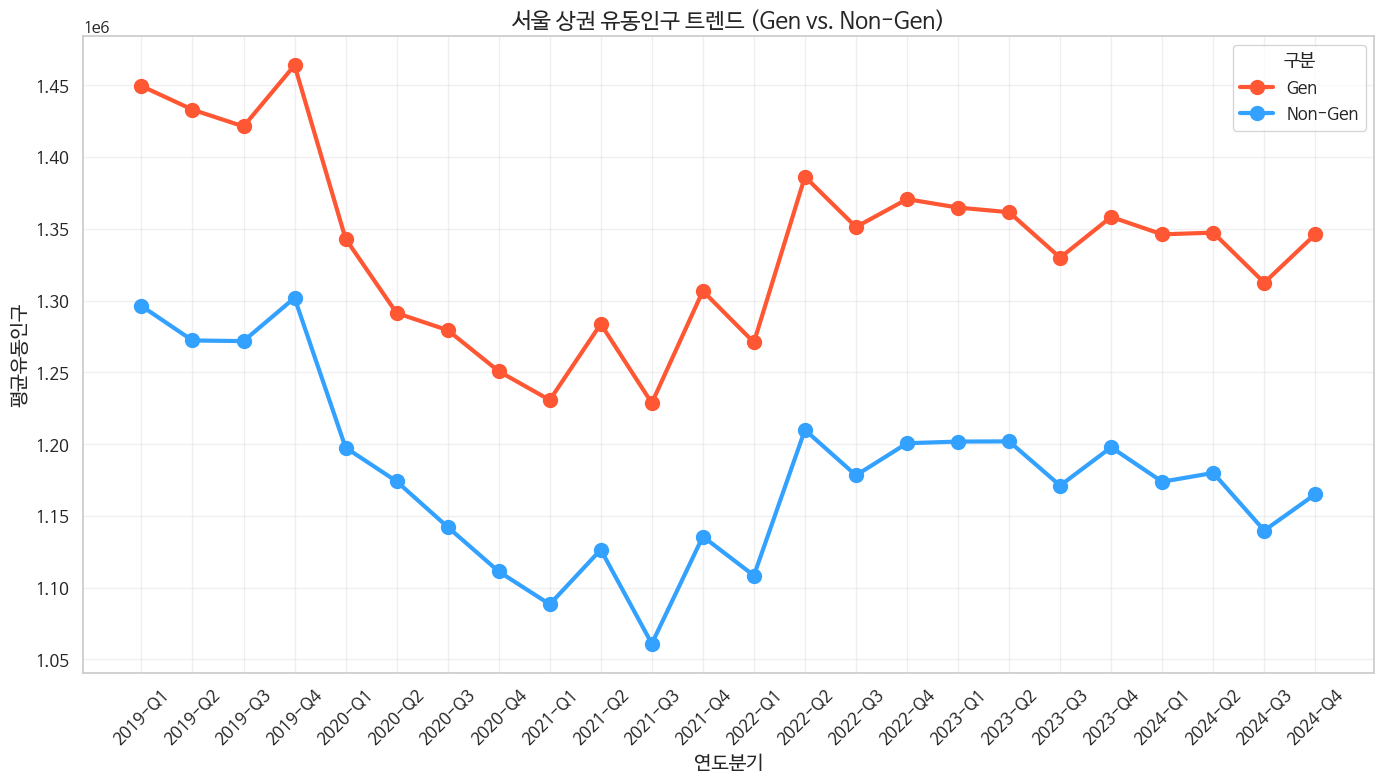

In [21]:
# 데이터 타입 변환
df_dong_floating_total['총유동인구수'] = pd.to_numeric(df_dong_floating_total['총유동인구수'], errors='coerce')

# 연도_분기 컬럼 변환
df_dong_floating_total['연도분기라벨'] = df_dong_floating_total['연도분기'].astype(str).apply(
  lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x
)

# 시계열 데이터
time_series_data = df_dong_floating_total.groupby(['연도분기', '연도분기라벨', '구분'])['총유동인구수'].mean().reset_index()
time_series_data = time_series_data.sort_values('연도분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_data = time_series_data[time_series_data['구분'] == '젠트리피케이션']
non_gen_data = time_series_data[time_series_data['구분'] == '비젠트리피케이션']

# 그래프 크기 설정
plt.figure(figsize=(14, 8))

# 선 그래프 그리기
plt.plot(gen_data['연도분기라벨'], gen_data['총유동인구수'], 'o-', color='#FF5733', linewidth=3, markersize=10)
plt.plot(non_gen_data['연도분기라벨'], non_gen_data['총유동인구수'], 'o-', color='#33A1FF', linewidth=3, markersize=10)

# 그래프 그리기
plt.title('서울 상권 유동인구 트렌드 (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('연도분기', fontsize=14)
plt.ylabel('평균유동인구', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Gen', 'Non-Gen'], title='구분', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

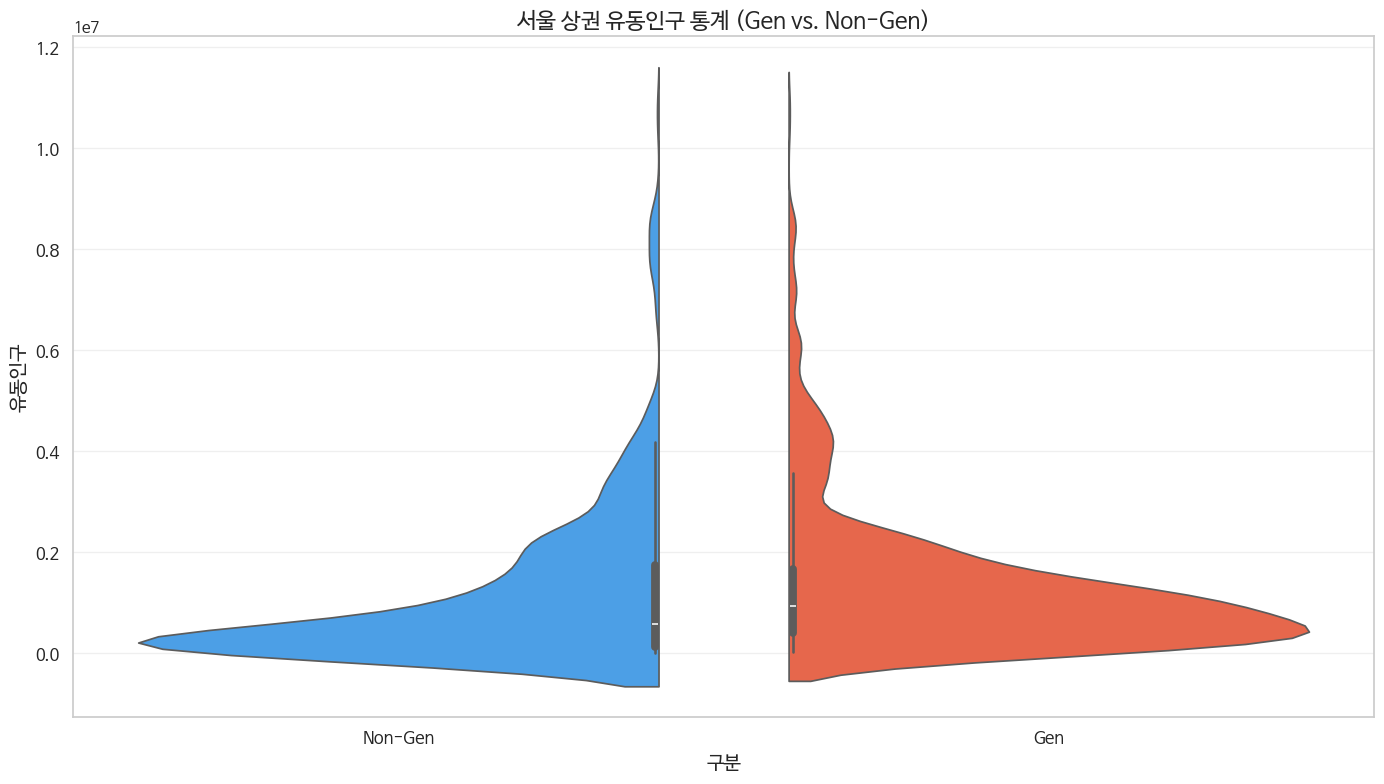

In [22]:
# 그래프 크기 설정
plt.figure(figsize=(14, 8))

# 분할된 바이올린 플롯 데이터 준비
violin_data = df_dong_floating_total.copy()
violin_data['구분'] = violin_data['구분'].map({
  '젠트리피케이션': 'Gen',
  '비젠트리피케이션': 'Non-Gen'
})

# 바이올린 플롯 그리기
ax = sns.violinplot(
  x='구분',
  y='총유동인구수',
  hue='구분',
  data=violin_data,
  palette={'Gen': '#FF5733', 'Non-Gen': '#33A1FF'},
  inner='box',
  split=True
)

# 그래프 그리기
plt.title('서울 상권 유동인구 통계 (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('구분', fontsize=14)
plt.ylabel('유동인구', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 상권 유동인구 (성별)

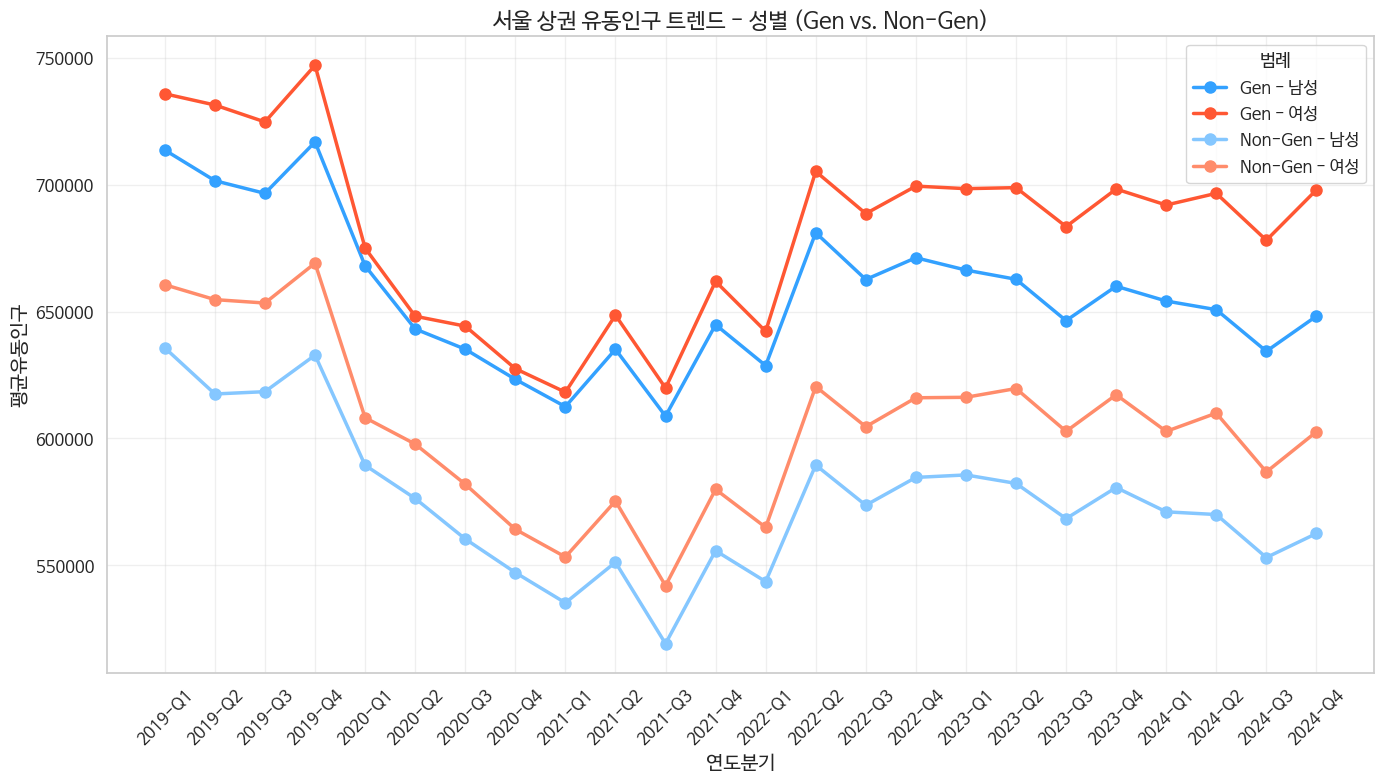

In [23]:
# 데이터 타입 변환
df_dong_floating_sex['남성유동인구수'] = pd.to_numeric(df_dong_floating_sex['남성유동인구수'], errors='coerce')
df_dong_floating_sex['여성유동인구수'] = pd.to_numeric(df_dong_floating_sex['여성유동인구수'], errors='coerce')

# 연도_분기 컬럼 변환
df_dong_floating_sex['연도분기라벨'] = df_dong_floating_sex['연도분기'].astype(str).apply(
  lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x
)

# 시계열 데이터
gender_time_series = df_dong_floating_sex.groupby(['연도분기', '연도분기라벨', '구분']).agg({'남성유동인구수': 'mean', '여성유동인구수': 'mean'}).reset_index()
gender_time_series = gender_time_series.sort_values('연도분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_gender_data = gender_time_series[gender_time_series['구분'] == '젠트리피케이션']
non_gen_gender_data = gender_time_series[gender_time_series['구분'] == '비젠트리피케이션']

# 그래프 크기 설정
plt.figure(figsize=(14, 8))

# 젠트리피케이션 지역의 남성/여성 유동인구
plt.plot(gen_gender_data['연도분기라벨'], gen_gender_data['남성유동인구수'], 'o-', color='#33A1FF', linewidth=2.5, markersize=8, label='Gen - 남성')
plt.plot(gen_gender_data['연도분기라벨'], gen_gender_data['여성유동인구수'], 'o-', color='#FF5733', linewidth=2.5, markersize=8, label='Gen - 여성')

# 비젠트리피케이션 지역의 남성/여성 유동인구
plt.plot(non_gen_gender_data['연도분기라벨'], non_gen_gender_data['남성유동인구수'], 'o-', color='#85C7FF', linewidth=2.5, markersize=8, label='Non-Gen - 남성')
plt.plot(non_gen_gender_data['연도분기라벨'], non_gen_gender_data['여성유동인구수'], 'o-', color='#FF8C6B', linewidth=2.5, markersize=8, label='Non-Gen - 여성')

# 그래프 그리기
plt.title('서울 상권 유동인구 트렌드 - 성별 (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('연도분기', fontsize=14)
plt.ylabel('평균유동인구', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='범례', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

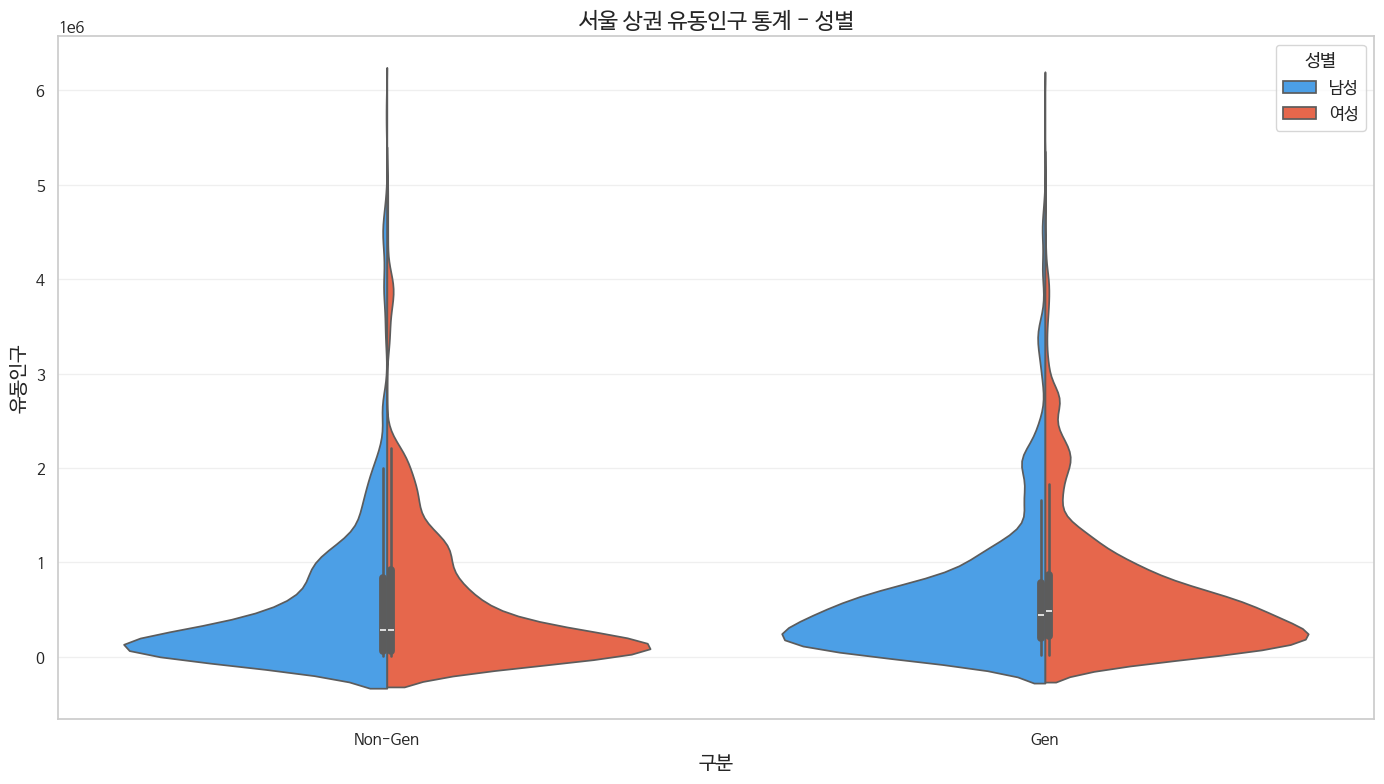

In [24]:
# 데이터 멜팅
violin_sex_data = pd.melt(
  df_dong_floating_sex,
  id_vars=['구분', '상권그룹', '연도분기'],
  value_vars=['남성유동인구수', '여성유동인구수'],
  var_name='성별',
  value_name='유동인구수'
)

# 성별 레이블 변환
violin_sex_data['성별'] = violin_sex_data['성별'].map({
  '남성유동인구수': '남성',
  '여성유동인구수': '여성'
})

# 구분 레이블 변환
violin_sex_data['구분'] = violin_sex_data['구분'].map({
  '젠트리피케이션': 'Gen',
  '비젠트리피케이션': 'Non-Gen'
})

# 그래프 크기 설정
plt.figure(figsize=(14, 8))

# X축이 구분, hue가 성별인 분할된 바이올린 플롯 생성
ax = sns.violinplot(
  x='구분',
  y='유동인구수',
  hue='성별',
  data=violin_sex_data,
  palette={'남성': '#33A1FF', '여성': '#FF5733'},
  split=True,
  inner='box',
  density_norm='width'
)

# 그래프 그리기
plt.title('서울 상권 유동인구 통계 - 성별', fontsize=16)
plt.xlabel('구분', fontsize=14)
plt.ylabel('유동인구', fontsize=14)
plt.legend(title='성별', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 상권 유동인구 (연령대)

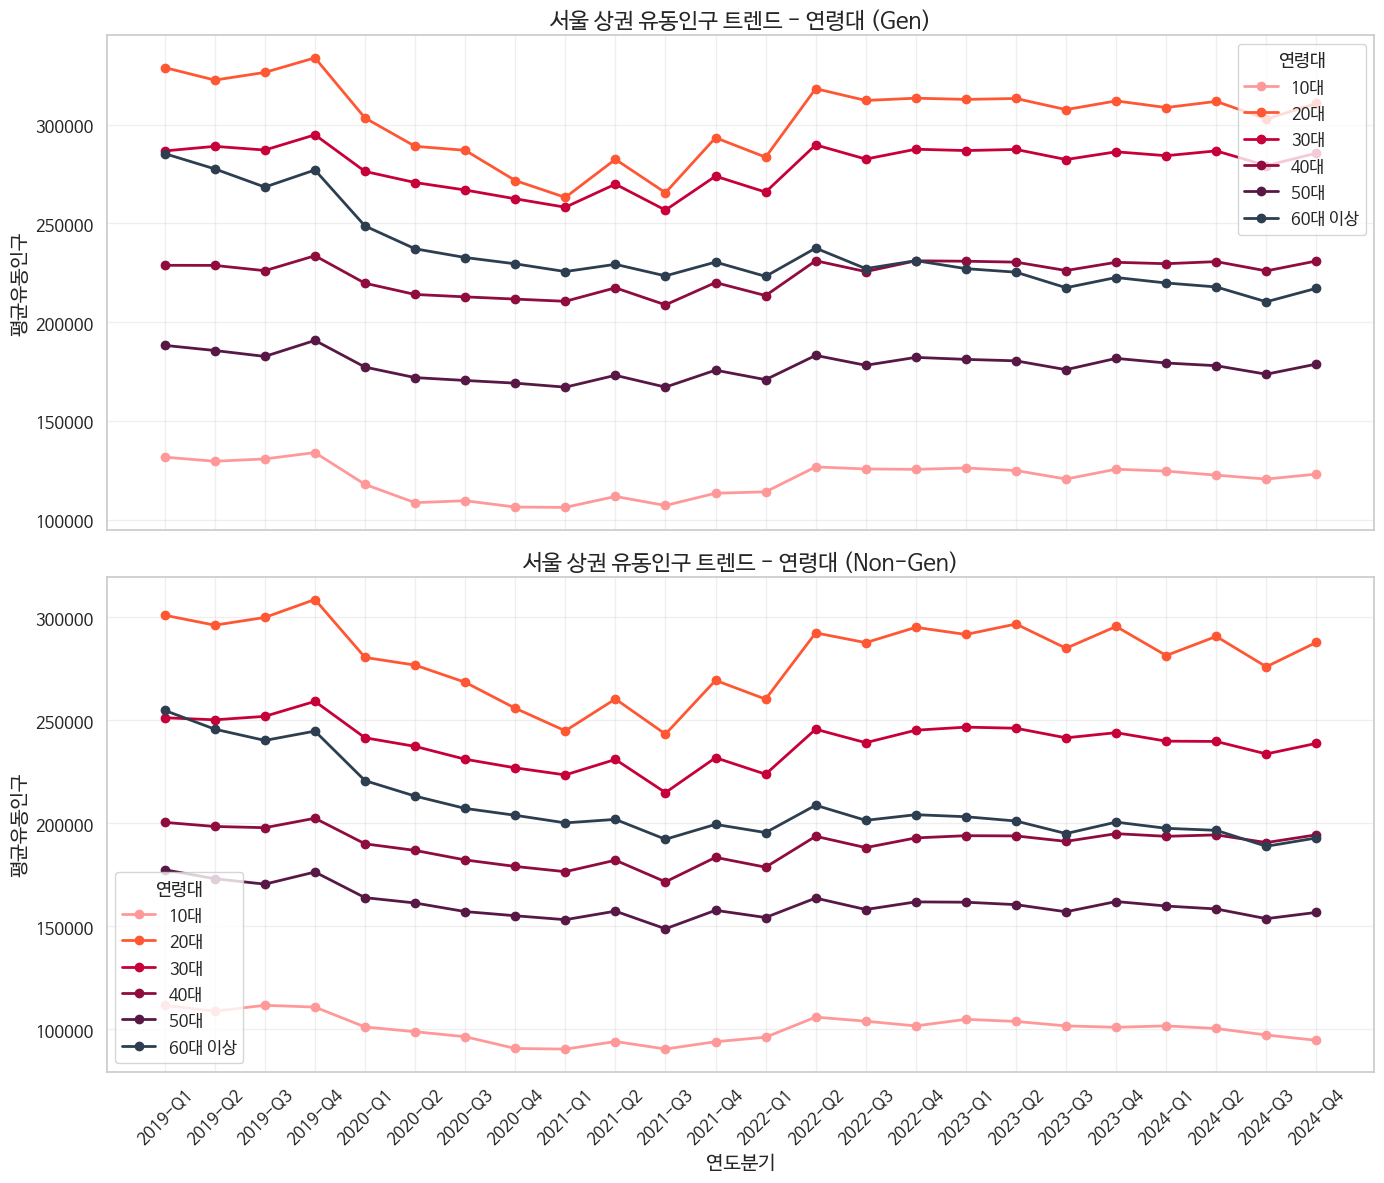

In [25]:
# 연령대 레이블 정의
age_labels = {
  "연령대10유동인구수": "10대",
  "연령대20유동인구수": "20대",
  "연령대30유동인구수": "30대",
  "연령대40유동인구수": "40대",
  "연령대50유동인구수": "50대",
  "연령대60이상유동인구수": "60대 이상"
}

# 데이터 타입 변환
age_columns = [
  "연령대10유동인구수", "연령대20유동인구수", "연령대30유동인구수",
  "연령대40유동인구수", "연령대50유동인구수", "연령대60이상유동인구수"
]

# 연령대별 색상 지정
age_colors = {
  "연령대10유동인구수": "#FF9999",
  "연령대20유동인구수": "#FF5733",
  "연령대30유동인구수": "#C70039",
  "연령대40유동인구수": "#900C3F",
  "연령대50유동인구수": "#581845",
  "연령대60이상유동인구수": "#2C3E50"
}

# 데이터 타입 변환
for col in age_columns:
  df_dong_floating_age[col] = pd.to_numeric(df_dong_floating_age[col], errors='coerce')

# 연도_분기 컬럼 변환
df_dong_floating_age['연도분기라벨'] = df_dong_floating_age['연도분기'].astype(str).apply(
  lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x
)

# 연령대별 시계열 데이터 준비
age_time_series = df_dong_floating_age.groupby(['연도분기', '연도분기라벨', '구분']).agg({col: 'mean' for col in age_columns}).reset_index()
age_time_series = age_time_series.sort_values('연도분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_age_data = age_time_series[age_time_series['구분'] == '젠트리피케이션']
non_gen_age_data = age_time_series[age_time_series['구분'] == '비젠트리피케이션']

# 두 개의 서브플롯 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# 젠트리피케이션 지역의 연령대별 유동인구 시계열 그래프
for col in age_columns:
  ax1.plot(gen_age_data['연도분기라벨'], gen_age_data[col], 'o-', color=age_colors[col], linewidth=2, markersize=6, label=age_labels[col])

ax1.set_title('서울 상권 유동인구 트렌드 - 연령대 (Gen)', fontsize=16)
ax1.set_ylabel('평균유동인구', fontsize=14)
ax1.tick_params(axis='y', labelsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(title='연령대', fontsize=12, title_fontsize=13)

# 비젠트리피케이션 지역의 연령대별 유동인구 시계열 그래프
for col in age_columns:
  ax2.plot(non_gen_age_data['연도분기라벨'], non_gen_age_data[col], 'o-', color=age_colors[col], linewidth=2, markersize=6, label=age_labels[col])

ax2.set_title('서울 상권 유동인구 트렌드 - 연령대 (Non-Gen)', fontsize=16)
ax2.set_xlabel('연도분기', fontsize=14)
ax2.set_ylabel('평균유동인구', fontsize=14)
ax2.tick_params(axis='x', rotation=45, labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(title='연령대', fontsize=12, title_fontsize=13)

# 그래프 그리기
plt.tight_layout()
plt.show()

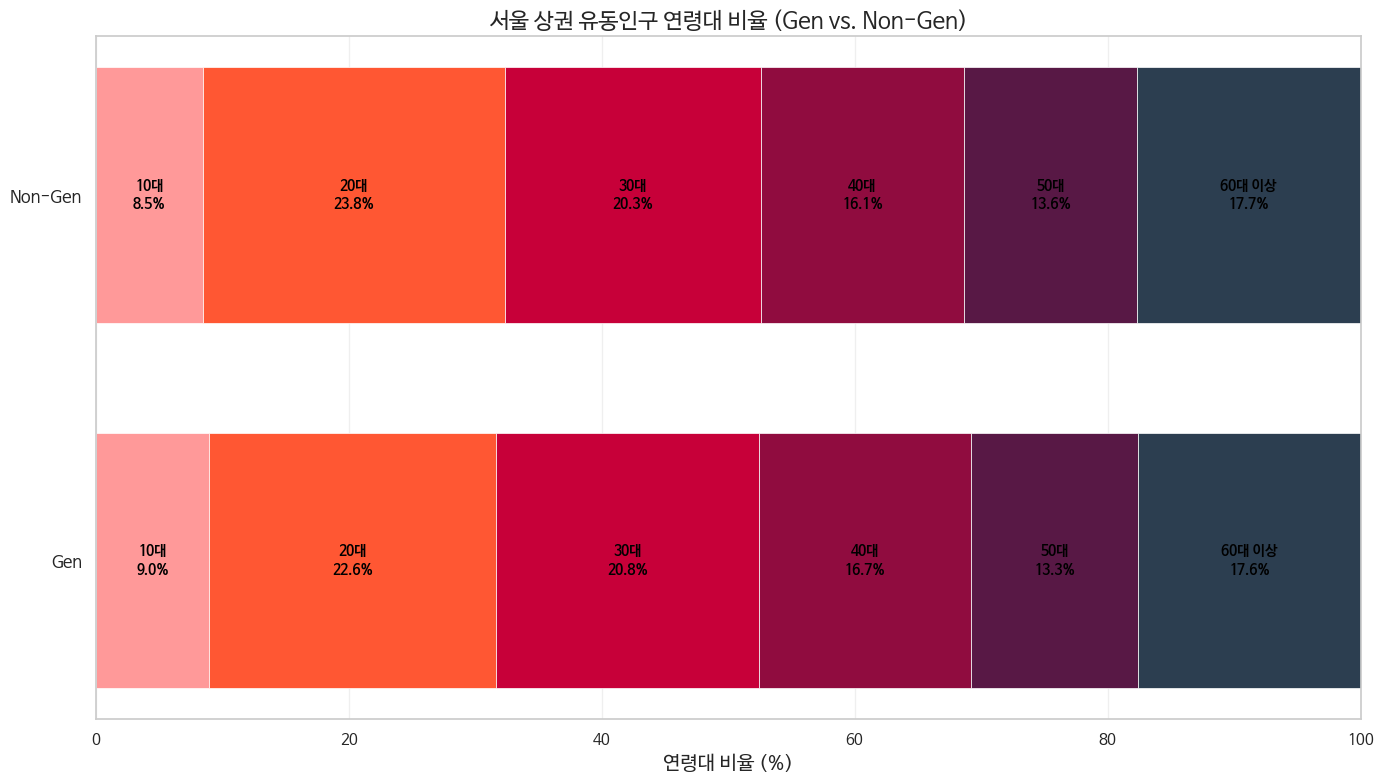

In [26]:
# 각 구분별, 연령대별 평균 유동인구 계산
age_means = df_dong_floating_age.groupby('구분')[age_columns].mean().reset_index()

# 각 행(구분)별로 총 합계 계산하여 비율 구하기
for idx, row in age_means.iterrows():
  total = row[age_columns].sum()
  for col in age_columns:
    age_means.loc[idx, f'{col}_비율'] = row[col] / total * 100

# 데이터 재구성 (멜팅)
ratio_columns = [f'{col}_비율' for col in age_columns]
age_ratio_melted = pd.melt(
  age_means,
  id_vars=['구분'],
  value_vars=ratio_columns,
  var_name='연령대_비율',
  value_name='비율'
)

# 연령대 레이블 변환
age_ratio_melted['연령대'] = age_ratio_melted['연령대_비율'].apply(lambda x: age_labels[x.replace('_비율', '')])
age_ratio_melted['구분'] = age_ratio_melted['구분'].map({
  '젠트리피케이션': 'Gen',
  '비젠트리피케이션': 'Non-Gen'
})

# 연령대 순서 정의
age_order = ['10대', '20대', '30대', '40대', '50대', '60대 이상']

# 연령대 순서 컬럼 추가
age_ratio_melted['연령대순서'] = age_ratio_melted['연령대'].map({age: i for i, age in enumerate(age_order)})
age_ratio_melted = age_ratio_melted.sort_values(['구분', '연령대순서'])

# 색상 팔레트 정의 (연령대별)
colors = ['#FF9999', '#FF5733', '#C70039', '#900C3F', '#581845', '#2C3E50']
palette = {age: color for age, color in zip(age_order, colors)}

# 그래프 크기 설정
plt.figure(figsize=(14, 8))

# 젠트리피케이션과 비젠트리피케이션을 구분하여 그래프 생성
for i, category in enumerate(['Gen', 'Non-Gen']):
  # 해당 카테고리 데이터만 필터링
  category_data = age_ratio_melted[age_ratio_melted['구분'] == category]

  # 위치 설정 (젠트리피케이션: 0, 비젠트리피케이션: 1)
  y_pos = i

  # 누적 시작 위치
  left = 0

  # 각 연령대별로 막대 그리기
  for age in age_order:
    # 해당 연령대 데이터 찾기
    age_data = category_data[category_data['연령대'] == age]

    if not age_data.empty:
      width = age_data['비율'].values[0]
      plt.barh(y_pos, width, left=left, height=0.7, color=palette[age], edgecolor='white', linewidth=0.5)

      # 비율이 5% 이상인 경우에만 레이블 표시
      if width >= 5:
        # 텍스트 위치 계산 (막대 중앙)
        text_x = left + width / 2
        plt.text(text_x, y_pos, f"{age}\n{width:.1f}%", ha='center', va='center', color='black', fontsize=10, fontweight='bold')

      # 다음 막대의 시작 위치 업데이트
      left += width

# 그래프 그리기
plt.yticks([0, 1], ['Gen', 'Non-Gen'], fontsize=12)
plt.xlabel('연령대 비율 (%)', fontsize=14)
plt.xlim(0, 100)
plt.title('서울 상권 유동인구 연령대 비율 (Gen vs. Non-Gen)', fontsize=16)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### 상권 상주인구 (총 인구 수)

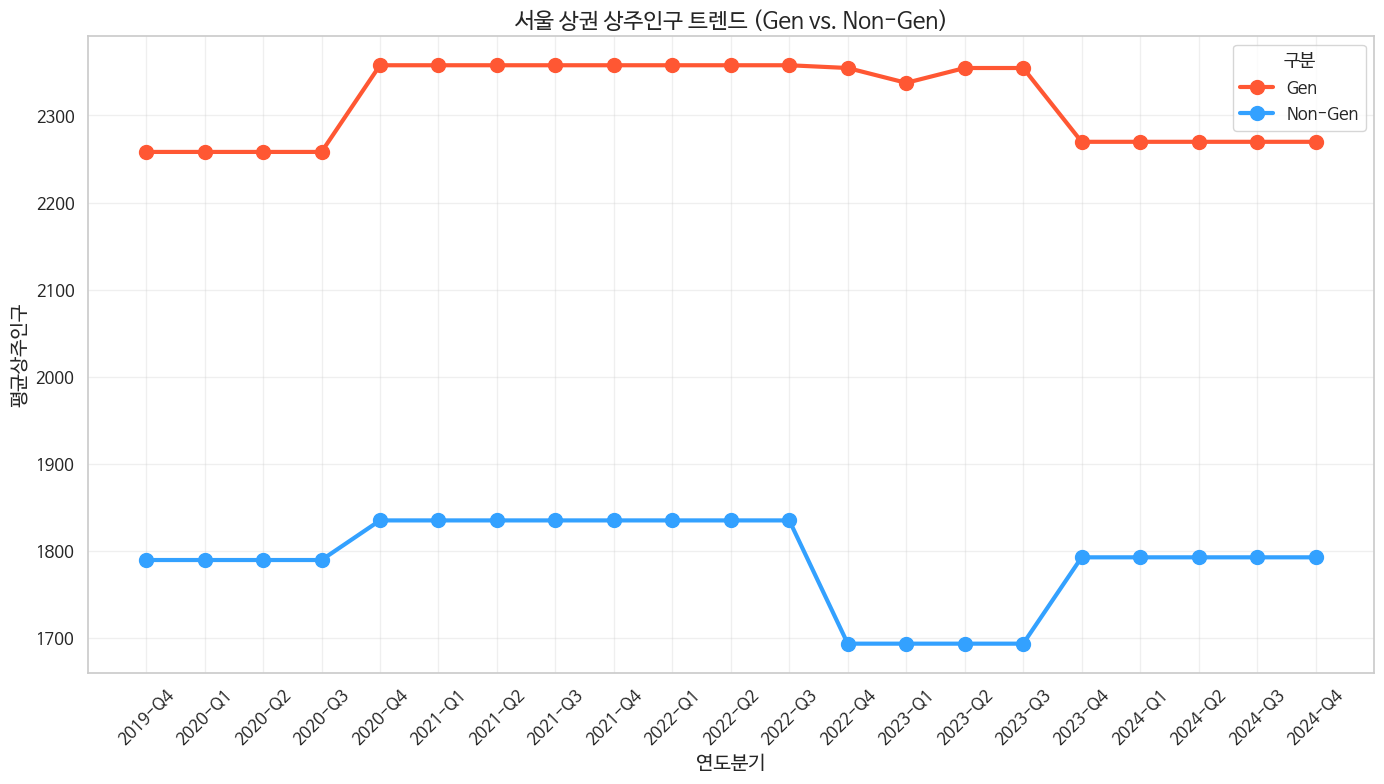

In [27]:
# 데이터 타입 변환
df_dong_resident_total['총상주인구수'] = pd.to_numeric(df_dong_resident_total['총상주인구수'], errors='coerce')

# 연도_분기 컬럼 변환
df_dong_resident_total['연도분기라벨'] = df_dong_resident_total['연도분기'].astype(str).apply(
  lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x
)

# 시계열 데이터
time_series_data = df_dong_resident_total.groupby(['연도분기', '연도분기라벨', '구분'])['총상주인구수'].mean().reset_index()
time_series_data = time_series_data.sort_values('연도분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_data = time_series_data[time_series_data['구분'] == '젠트리피케이션']
non_gen_data = time_series_data[time_series_data['구분'] == '비젠트리피케이션']

# 그래프 크기 설정
plt.figure(figsize=(14, 8))

# 선 그래프 그리기
plt.plot(gen_data['연도분기라벨'], gen_data['총상주인구수'], 'o-', color='#FF5733', linewidth=3, markersize=10)
plt.plot(non_gen_data['연도분기라벨'], non_gen_data['총상주인구수'], 'o-', color='#33A1FF', linewidth=3, markersize=10)

# 그래프 스타일 설정
plt.title('서울 상권 상주인구 트렌드 (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('연도분기', fontsize=14)
plt.ylabel('평균상주인구', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Gen', 'Non-Gen'], title='구분', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

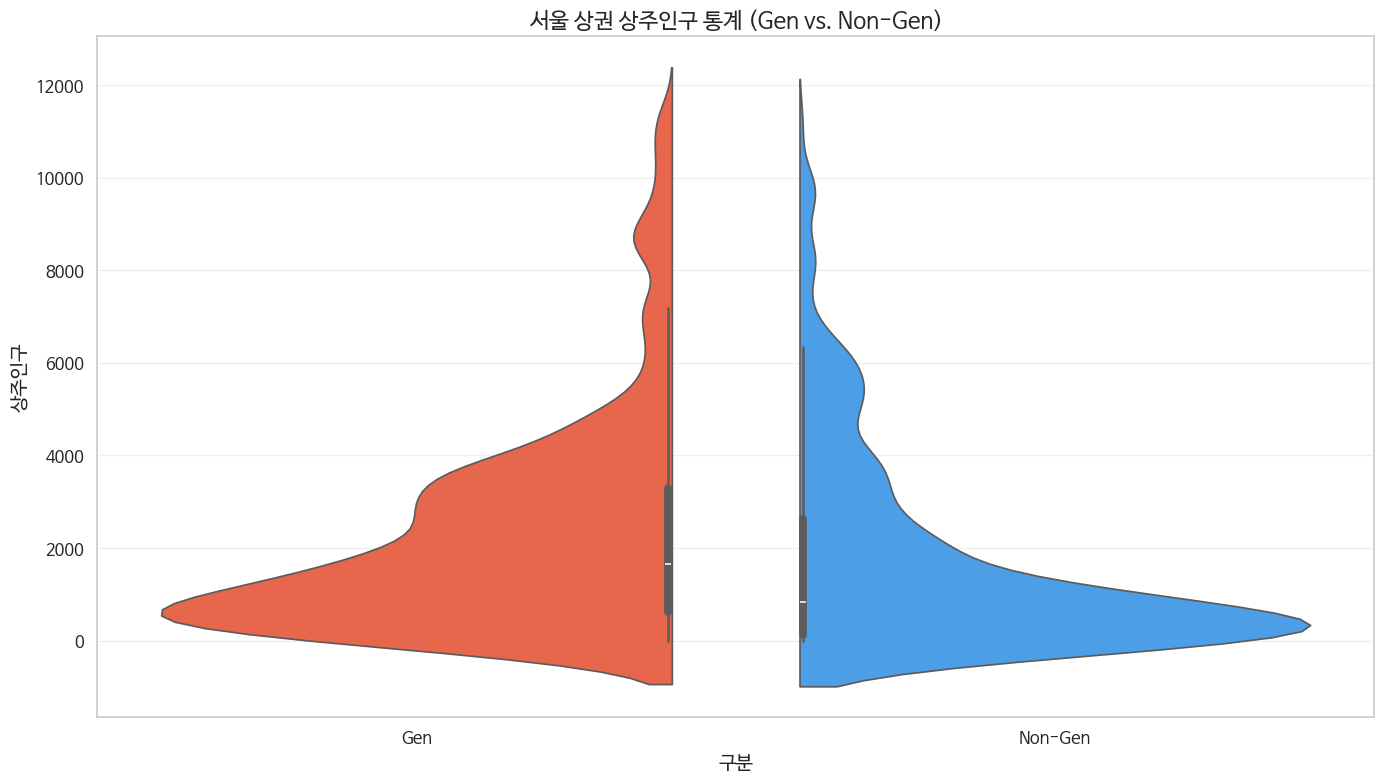

In [28]:
# 그래프 크기 설정
plt.figure(figsize=(14, 8))

# 분할된 바이올린 플롯 데이터 준비
violin_data = df_dong_resident_total.copy()
violin_data['구분'] = violin_data['구분'].map({
  '젠트리피케이션': 'Gen',
  '비젠트리피케이션': 'Non-Gen'
})

# 바이올린 플롯 그리기
ax = sns.violinplot(
  x='구분',
  y='총상주인구수',
  hue='구분',
  data=violin_data,
  palette={'Gen': '#FF5733', 'Non-Gen': '#33A1FF'},
  inner='box',
  split=True
)

# 그래프 그리기
plt.title('서울 상권 상주인구 통계 (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('구분', fontsize=14)
plt.ylabel('상주인구', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 상권 상주인구 (성별)

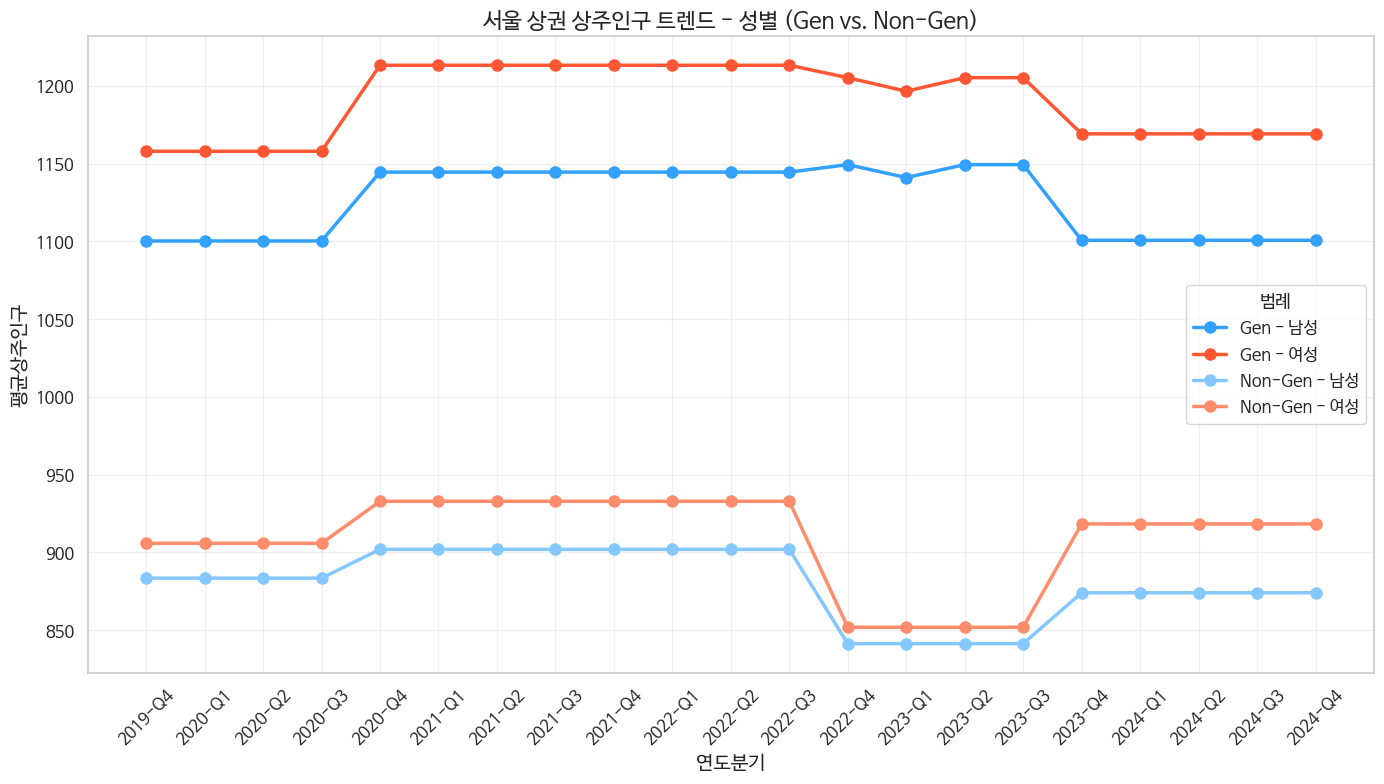

In [29]:
# 데이터 타입 변환
df_dong_resident_sex['남성상주인구수'] = pd.to_numeric(df_dong_resident_sex['남성상주인구수'], errors='coerce')
df_dong_resident_sex['여성상주인구수'] = pd.to_numeric(df_dong_resident_sex['여성상주인구수'], errors='coerce')

# 연도_분기 컬럼 변환
df_dong_resident_sex['연도분기라벨'] = df_dong_resident_sex['연도분기'].astype(str).apply(
  lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x
)

# 시계열 데이터
gender_time_series = df_dong_resident_sex.groupby(['연도분기', '연도분기라벨', '구분']).agg({'남성상주인구수': 'mean', '여성상주인구수': 'mean'}).reset_index()
gender_time_series = gender_time_series.sort_values('연도분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_gender_data = gender_time_series[gender_time_series['구분'] == '젠트리피케이션']
non_gen_gender_data = gender_time_series[gender_time_series['구분'] == '비젠트리피케이션']

# 그래프 크기 설정
plt.figure(figsize=(14, 8))

# 젠트리피케이션 지역의 남성/여성 상주인구
plt.plot(gen_gender_data['연도분기라벨'], gen_gender_data['남성상주인구수'], 'o-', color='#33A1FF', linewidth=2.5, markersize=8, label='Gen - 남성')
plt.plot(gen_gender_data['연도분기라벨'], gen_gender_data['여성상주인구수'], 'o-', color='#FF5733', linewidth=2.5, markersize=8, label='Gen - 여성')

# 비젠트리피케이션 지역의 남성/여성 상주인구
plt.plot(non_gen_gender_data['연도분기라벨'], non_gen_gender_data['남성상주인구수'], 'o-', color='#85C7FF', linewidth=2.5, markersize=8, label='Non-Gen - 남성')
plt.plot(non_gen_gender_data['연도분기라벨'], non_gen_gender_data['여성상주인구수'], 'o-', color='#FF8C6B', linewidth=2.5, markersize=8, label='Non-Gen - 여성')

# 그래프 그리기
plt.title('서울 상권 상주인구 트렌드 - 성별 (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('연도분기', fontsize=14)
plt.ylabel('평균상주인구', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='범례', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

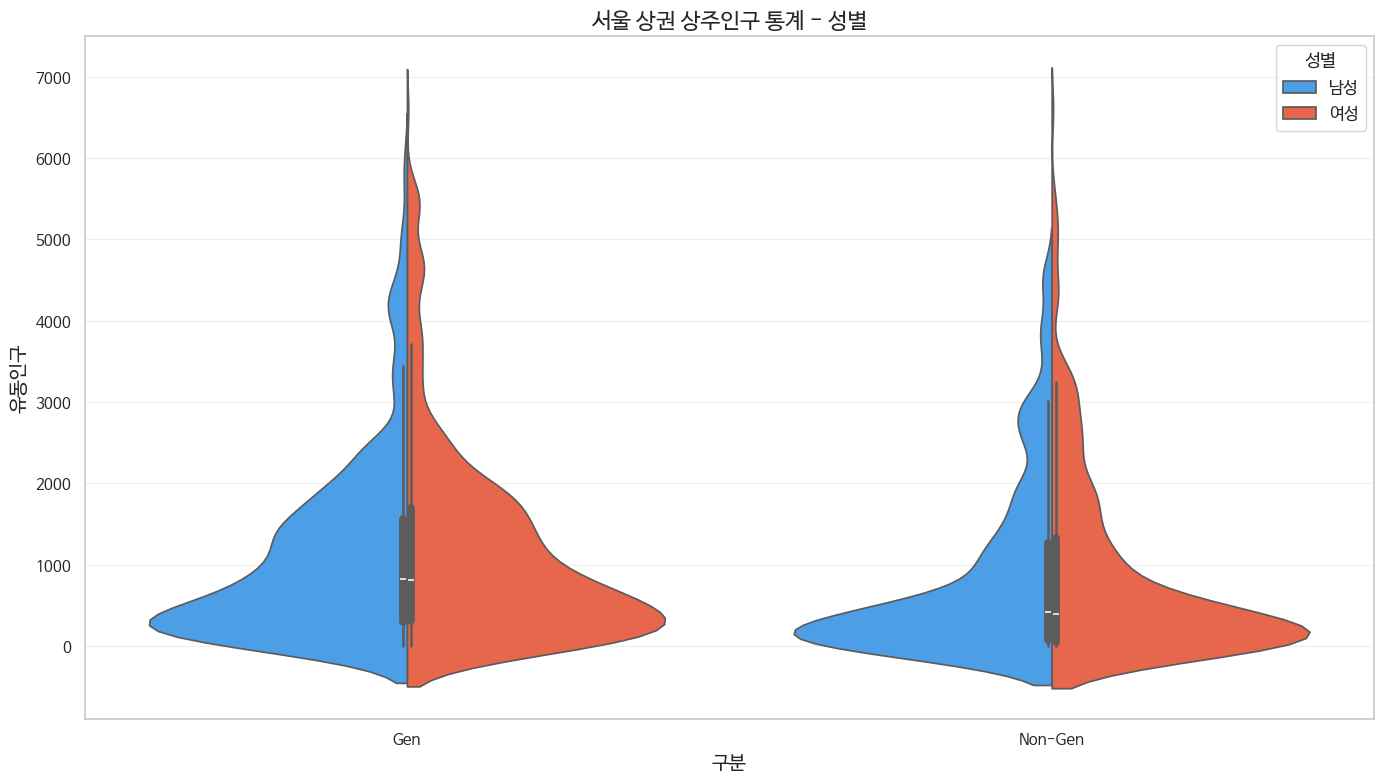

In [30]:
# 데이터 멜팅
violin_sex_data = pd.melt(
  df_dong_resident_sex,
  id_vars=['구분', '상권그룹', '연도분기'],
  value_vars=['남성상주인구수', '여성상주인구수'],
  var_name='성별',
  value_name='상주인구수'
)

# 성별 레이블 변환
violin_sex_data['성별'] = violin_sex_data['성별'].map({
  '남성상주인구수': '남성',
  '여성상주인구수': '여성'
})

# 구분 레이블 변환
violin_sex_data['구분'] = violin_sex_data['구분'].map({
  '젠트리피케이션': 'Gen',
  '비젠트리피케이션': 'Non-Gen'
})

# 그래프 크기 설정
plt.figure(figsize=(14, 8))

# X축이 구분(젠/비젠), hue가 성별인 분할된 바이올린 플롯 생성
ax=sns.violinplot(
  x='구분',
  y='상주인구수',
  hue='성별',
  data=violin_sex_data,
  palette={'남성': '#33A1FF', '여성': '#FF5733'},
  split=True,
  inner='box',
  density_norm='width'
)

# 그래프 그리기
plt.title('서울 상권 상주인구 통계 - 성별', fontsize=16)
plt.xlabel('구분', fontsize=14)
plt.ylabel('유동인구', fontsize=14)
plt.legend(title='성별', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 상권 상주인구 (연령대)

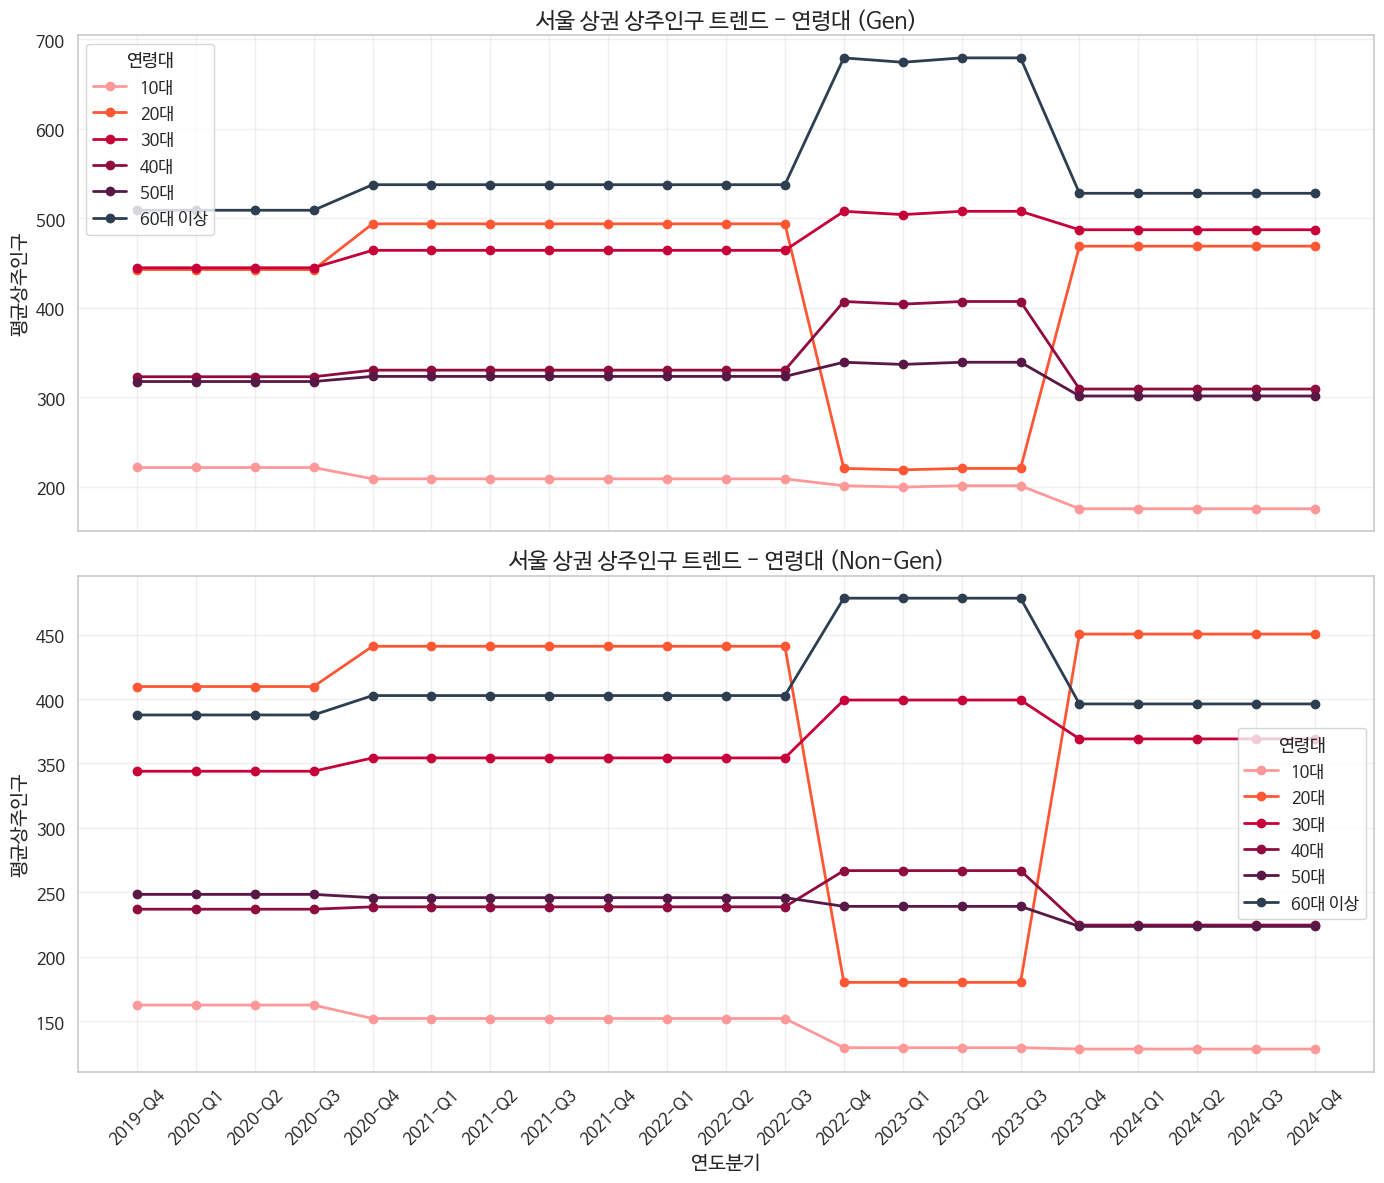

In [31]:
# 연령대 레이블 정의
age_labels = {
  "연령대10상주인구수": "10대",
  "연령대20상주인구수": "20대",
  "연령대30상주인구수": "30대",
  "연령대40상주인구수": "40대",
  "연령대50상주인구수": "50대",
  "연령대60이상상주인구수": "60대 이상"
}

# 데이터 타입 변환
age_columns = [
  "연령대10상주인구수", "연령대20상주인구수", "연령대30상주인구수",
  "연령대40상주인구수", "연령대50상주인구수", "연령대60이상상주인구수"
]

# 연령대별 색상 지정
age_colors = {
  "연령대10상주인구수": "#FF9999",
  "연령대20상주인구수": "#FF5733",
  "연령대30상주인구수": "#C70039",
  "연령대40상주인구수": "#900C3F",
  "연령대50상주인구수": "#581845",
  "연령대60이상상주인구수": "#2C3E50"
}

# 데이터 타입 변환
for col in age_columns:
  df_dong_resident_age[col] = pd.to_numeric(df_dong_resident_age[col], errors='coerce')

# 연도_분기 컬럼 변환
df_dong_resident_age['연도분기라벨'] = df_dong_resident_age['연도분기'].astype(str).apply(
  lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x
)

# 연령대별 시계열 데이터 준비
age_time_series = df_dong_resident_age.groupby(['연도분기', '연도분기라벨', '구분']).agg({col: 'mean' for col in age_columns}).reset_index()
age_time_series = age_time_series.sort_values('연도분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_age_data = age_time_series[age_time_series['구분'] == '젠트리피케이션']
non_gen_age_data = age_time_series[age_time_series['구분'] == '비젠트리피케이션']

# 두 개의 서브플롯 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# 젠트리피케이션 지역의 연령대별 상주인구 시계열 그래프
for col in age_columns:
  ax1.plot(gen_age_data['연도분기라벨'], gen_age_data[col], 'o-', color=age_colors[col], linewidth=2, markersize=6, label=age_labels[col])

ax1.set_title('서울 상권 상주인구 트렌드 - 연령대 (Gen)', fontsize=16)
ax1.set_ylabel('평균상주인구', fontsize=14)
ax1.tick_params(axis='y', labelsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(title='연령대', fontsize=12, title_fontsize=13)

# 비젠트리피케이션 지역의 연령대별 상주인구 시계열 그래프
for col in age_columns:
  ax2.plot(non_gen_age_data['연도분기라벨'], non_gen_age_data[col], 'o-', color=age_colors[col], linewidth=2, markersize=6, label=age_labels[col])

ax2.set_title('서울 상권 상주인구 트렌드 - 연령대 (Non-Gen)', fontsize=16)
ax2.set_xlabel('연도분기', fontsize=14)
ax2.set_ylabel('평균상주인구', fontsize=14)
ax2.tick_params(axis='x', rotation=45, labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(title='연령대', fontsize=12, title_fontsize=13)

# 그래프 그리기
plt.tight_layout()
plt.show()

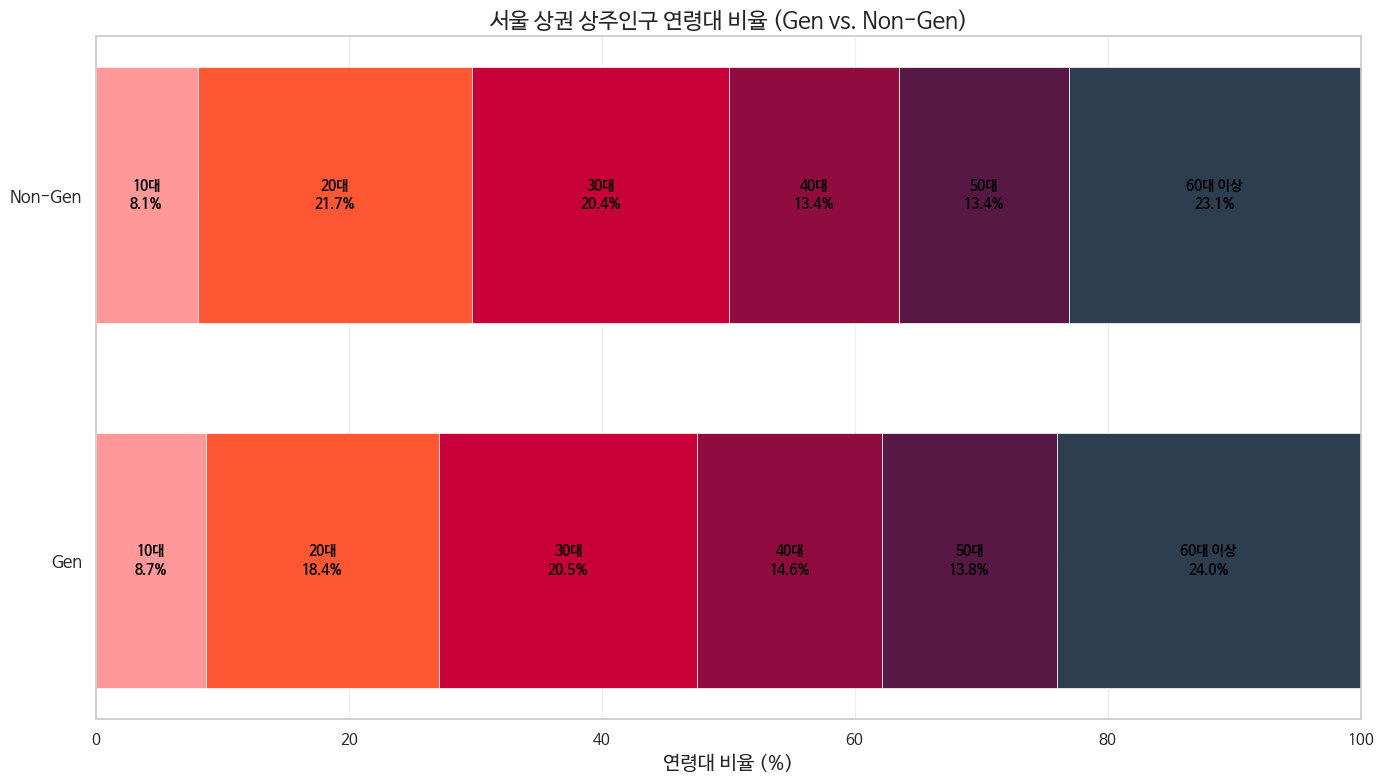

In [32]:
# 각 구분별, 연령대별 평균 상주인구 계산
age_means = df_dong_resident_age.groupby('구분')[age_columns].mean().reset_index()

# 각 행(구분)별로 총 합계 계산하여 비율 구하기
for idx, row in age_means.iterrows():
  total = row[age_columns].sum()
  for col in age_columns:
    age_means.loc[idx, f'{col}_비율'] = row[col] / total * 100

# 데이터 재구성 (멜팅)
ratio_columns = [f'{col}_비율' for col in age_columns]
age_ratio_melted = pd.melt(
  age_means,
  id_vars=['구분'],
  value_vars=ratio_columns,
  var_name='연령대_비율',
  value_name='비율'
)

# 연령대 레이블 변환
age_ratio_melted['연령대'] = age_ratio_melted['연령대_비율'].apply(lambda x: age_labels[x.replace('_비율', '')])
age_ratio_melted['구분'] = age_ratio_melted['구분'].map({
  '젠트리피케이션': 'Gen',
  '비젠트리피케이션': 'Non-Gen'
})

# 연령대 순서 정의
age_order = ['10대', '20대', '30대', '40대', '50대', '60대 이상']

# 연령대 순서 컬럼 추가
age_ratio_melted['연령대순서'] = age_ratio_melted['연령대'].map({age: i for i, age in enumerate(age_order)})
age_ratio_melted = age_ratio_melted.sort_values(['구분', '연령대순서'])

# 색상 팔레트 정의 (연령대별)
colors = ['#FF9999', '#FF5733', '#C70039', '#900C3F', '#581845', '#2C3E50']
palette = {age: color for age, color in zip(age_order, colors)}

# 가로 누적 막대 그래프 그리기
plt.figure(figsize=(14, 8))

# 젠트리피케이션과 비젠트리피케이션을 구분하여 그래프 생성
for i, category in enumerate(['Gen', 'Non-Gen']):
  # 해당 카테고리 데이터만 필터링
  category_data = age_ratio_melted[age_ratio_melted['구분'] == category]

  # 위치 설정 (젠트리피케이션: 0, 비젠트리피케이션: 1)
  y_pos = i

  # 누적 시작 위치
  left = 0

  # 각 연령대별로 막대 그리기
  for age in age_order:
    # 해당 연령대 데이터 찾기
    age_data = category_data[category_data['연령대'] == age]

    if not age_data.empty:
      width = age_data['비율'].values[0]
      plt.barh(y_pos, width, left=left, height=0.7, color=palette[age], edgecolor='white', linewidth=0.5)

      # 비율이 5% 이상인 경우에만 레이블 표시
      if width >= 5:
        # 텍스트 위치 계산 (막대 중앙)
        text_x = left + width / 2
        plt.text(text_x, y_pos, f"{age}\n{width:.1f}%", ha='center', va='center', color='black', fontsize=10, fontweight='bold')

      # 다음 막대의 시작 위치 업데이트
      left += width

# 그래프 그리기
plt.yticks([0, 1], ['Gen', 'Non-Gen'], fontsize=12)
plt.xlabel('연령대 비율 (%)', fontsize=14)
plt.xlim(0, 100)
plt.title('서울 상권 상주인구 연령대 비율 (Gen vs. Non-Gen)', fontsize=16)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### 상권 직장인구 (총 인구 수)

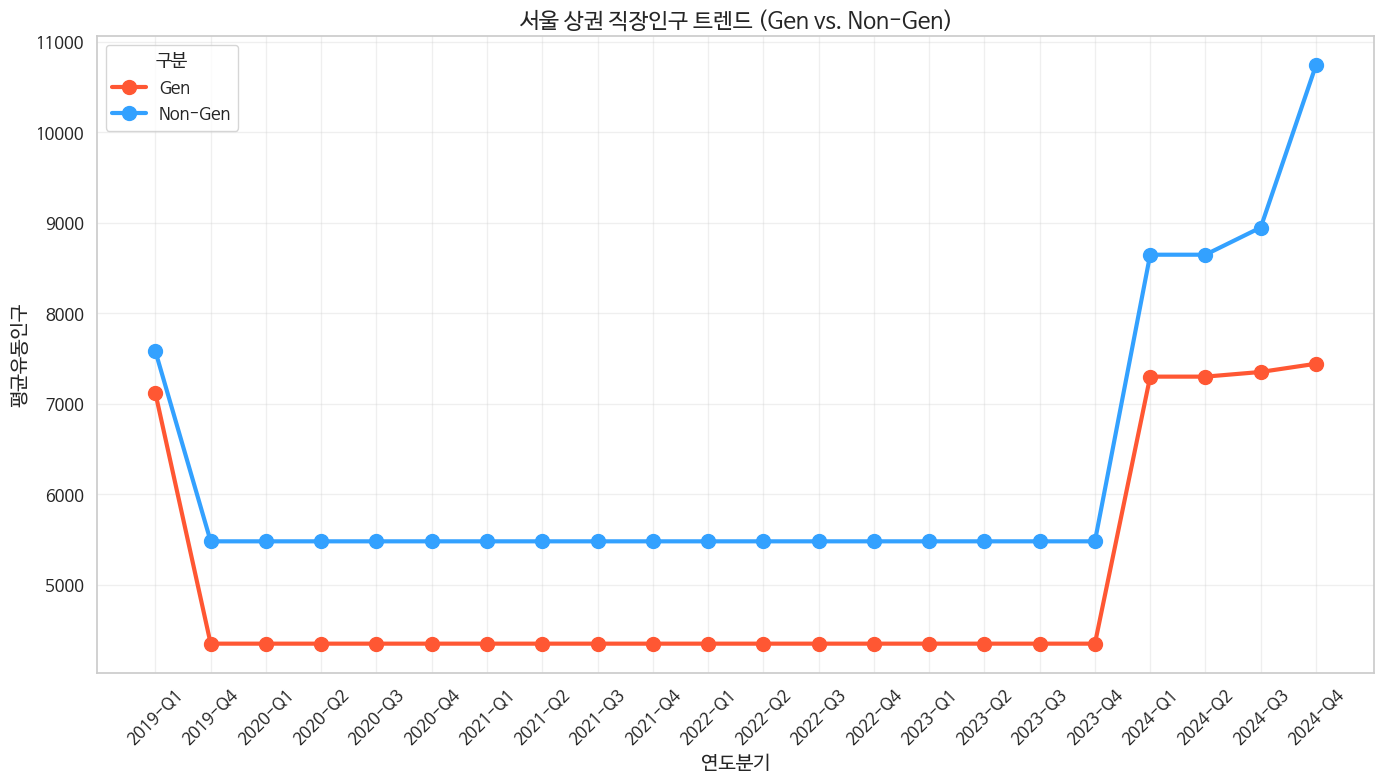

In [33]:
# 데이터 타입 변환
df_dong_working_total['총직장인구수'] = pd.to_numeric(df_dong_working_total['총직장인구수'], errors='coerce')

# 연도_분기 컬럼 변환
df_dong_working_total['연도분기라벨'] = df_dong_working_total['연도분기'].astype(str).apply(
  lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x
)

# 시계열 데이터
time_series_data = df_dong_working_total.groupby(['연도분기', '연도분기라벨', '구분'])['총직장인구수'].mean().reset_index()
time_series_data = time_series_data.sort_values('연도분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_data = time_series_data[time_series_data['구분'] == '젠트리피케이션']
non_gen_data = time_series_data[time_series_data['구분'] == '비젠트리피케이션']

# 그래프 크기 설정
plt.figure(figsize=(14, 8))

# 선 그래프 그리기
plt.plot(gen_data['연도분기라벨'], gen_data['총직장인구수'], 'o-', color='#FF5733', linewidth=3, markersize=10)
plt.plot(non_gen_data['연도분기라벨'], non_gen_data['총직장인구수'], 'o-', color='#33A1FF', linewidth=3, markersize=10)

# 그래프 그리기
plt.title('서울 상권 직장인구 트렌드 (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('연도분기', fontsize=14)
plt.ylabel('평균유동인구', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Gen', 'Non-Gen'], title='구분', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

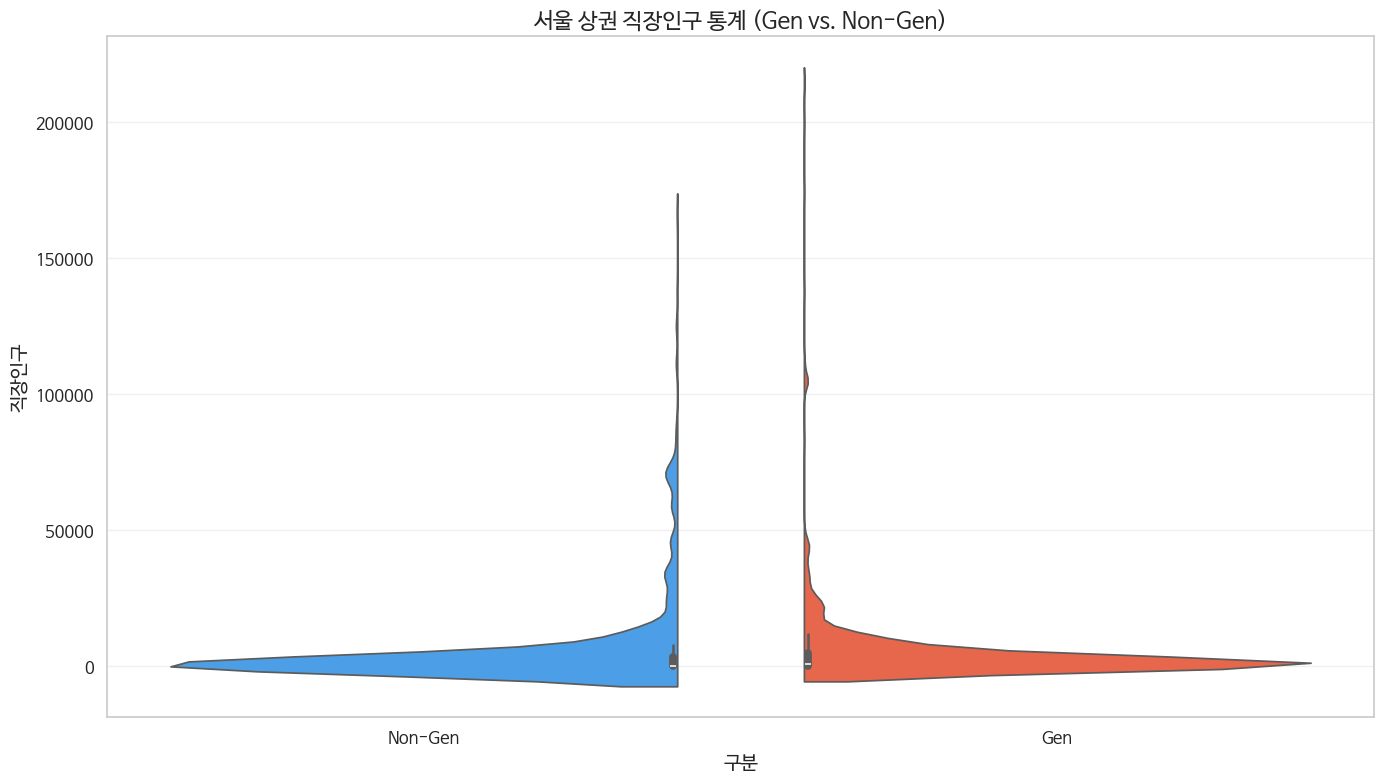

In [34]:
# 그래프 크기 설정
plt.figure(figsize=(14, 8))

# 분할된 바이올린 플롯 데이터 준비
violin_data = df_dong_working_total.copy()
violin_data['구분'] = violin_data['구분'].map({
  '젠트리피케이션': 'Gen',
  '비젠트리피케이션': 'Non-Gen'
})

# 바이올린 플롯 그리기
ax = sns.violinplot(
  x='구분',
  y='총직장인구수',
  hue='구분',
  data=violin_data,
  palette={'Gen': '#FF5733', 'Non-Gen': '#33A1FF'},
  inner='box',
  split=True
)

# 그래프 그리기
plt.title('서울 상권 직장인구 통계 (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('구분', fontsize=14)
plt.ylabel('직장인구', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 상권 직장인구 (성별)

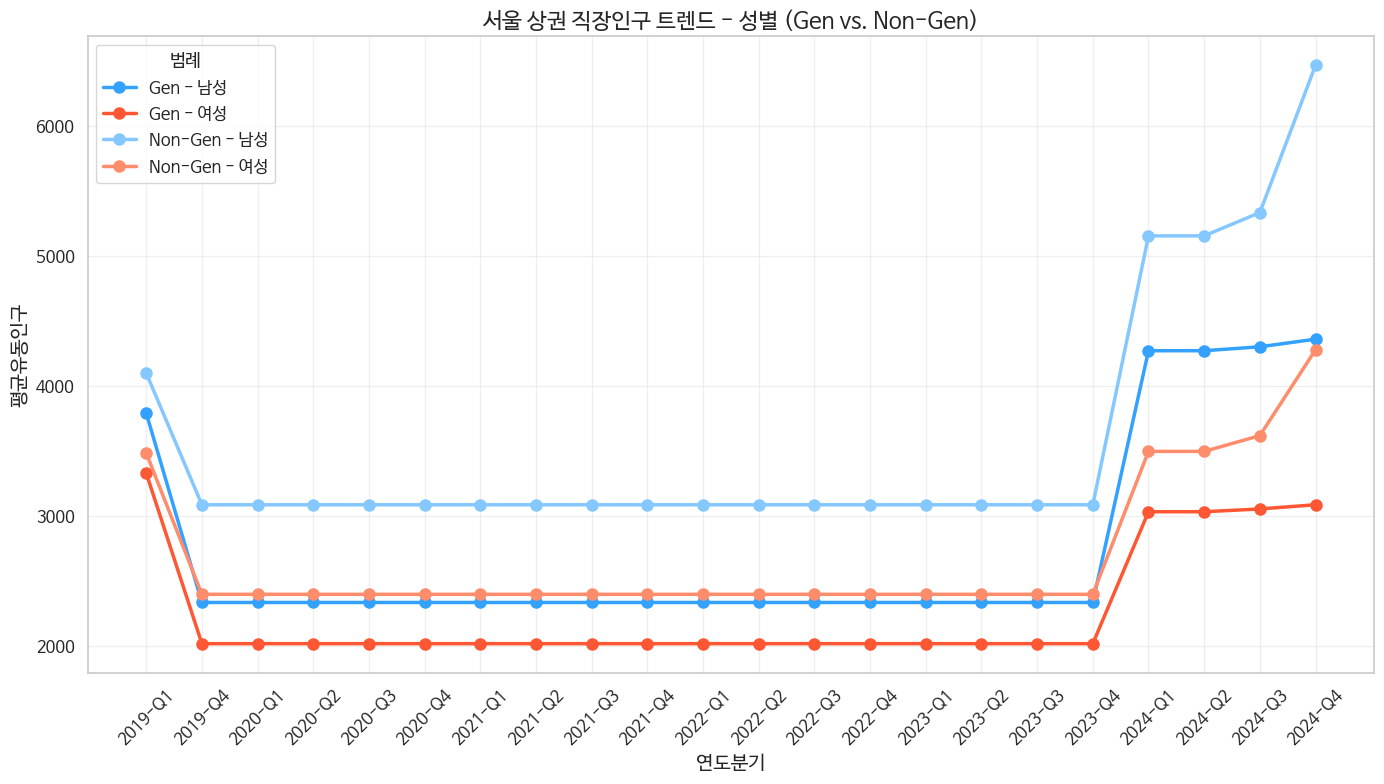

In [35]:
# 데이터 타입 변환
df_dong_working_sex['남성직장인구수'] = pd.to_numeric(df_dong_working_sex['남성직장인구수'], errors='coerce')
df_dong_working_sex['여성직장인구수'] = pd.to_numeric(df_dong_working_sex['여성직장인구수'], errors='coerce')

# 연도_분기 컬럼 변환
df_dong_working_sex['연도분기라벨'] = df_dong_working_sex['연도분기'].astype(str).apply(
  lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x
)

# 시계열 데이터
gender_time_series = df_dong_working_sex.groupby(['연도분기', '연도분기라벨', '구분']).agg({'남성직장인구수': 'mean', '여성직장인구수': 'mean'}).reset_index()
gender_time_series = gender_time_series.sort_values('연도분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_gender_data = gender_time_series[gender_time_series['구분'] == '젠트리피케이션']
non_gen_gender_data = gender_time_series[gender_time_series['구분'] == '비젠트리피케이션']

# 그래프 크기 설정
plt.figure(figsize=(14, 8))

# 젠트리피케이션 지역의 남성/여성 직장인구
plt.plot(gen_gender_data['연도분기라벨'], gen_gender_data['남성직장인구수'], 'o-', color='#33A1FF', linewidth=2.5, markersize=8, label='Gen - 남성')
plt.plot(gen_gender_data['연도분기라벨'], gen_gender_data['여성직장인구수'], 'o-', color='#FF5733', linewidth=2.5, markersize=8, label='Gen - 여성')

# 비젠트리피케이션 지역의 남성/여성 직장인구
plt.plot(non_gen_gender_data['연도분기라벨'], non_gen_gender_data['남성직장인구수'], 'o-', color='#85C7FF', linewidth=2.5, markersize=8, label='Non-Gen - 남성')
plt.plot(non_gen_gender_data['연도분기라벨'], non_gen_gender_data['여성직장인구수'], 'o-', color='#FF8C6B', linewidth=2.5, markersize=8, label='Non-Gen - 여성')

# 그래프 그리기
plt.title('서울 상권 직장인구 트렌드 - 성별 (Gen vs. Non-Gen)', fontsize=16)
plt.xlabel('연도분기', fontsize=14)
plt.ylabel('평균유동인구', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='범례', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

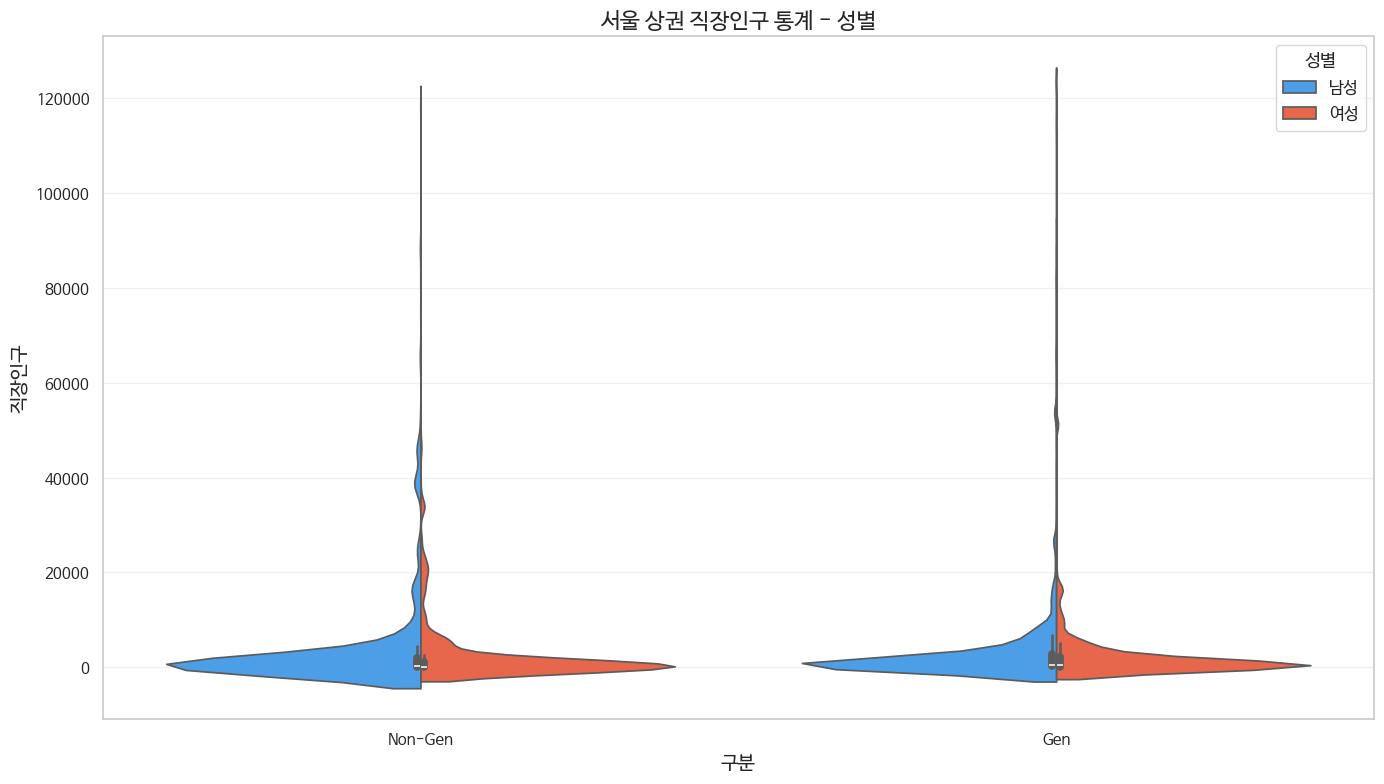

In [36]:
# 데이터 멜팅
violin_sex_data = pd.melt(
  df_dong_working_sex,
  id_vars=['구분', '상권그룹', '연도분기'],
  value_vars=['남성직장인구수', '여성직장인구수'],
  var_name='성별',
  value_name='직장인구수'
)

# 성별 레이블 변환
violin_sex_data['성별'] = violin_sex_data['성별'].map({
  '남성직장인구수': '남성',
  '여성직장인구수': '여성'
})

# 구분 레이블 변환
violin_sex_data['구분'] = violin_sex_data['구분'].map({
  '젠트리피케이션': 'Gen',
  '비젠트리피케이션': 'Non-Gen'
})

# 그래프 크기 설정
plt.figure(figsize=(14, 8))

# X축이 구분, hue가 성별인 분할된 바이올린 플롯 생성
ax = sns.violinplot(
  x='구분',
  y='직장인구수',
  hue='성별', 
  data=violin_sex_data,
  palette={'남성': '#33A1FF', '여성': '#FF5733'},
  split=True,
  inner='box',
  density_norm='width'
)

# 그래프 그리기
plt.title('서울 상권 직장인구 통계 - 성별', fontsize=16)
plt.xlabel('구분', fontsize=14)
plt.ylabel('직장인구', fontsize=14)
plt.legend(title='성별', fontsize=12, title_fontsize=13)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### 상권 직장인구 (연령대)

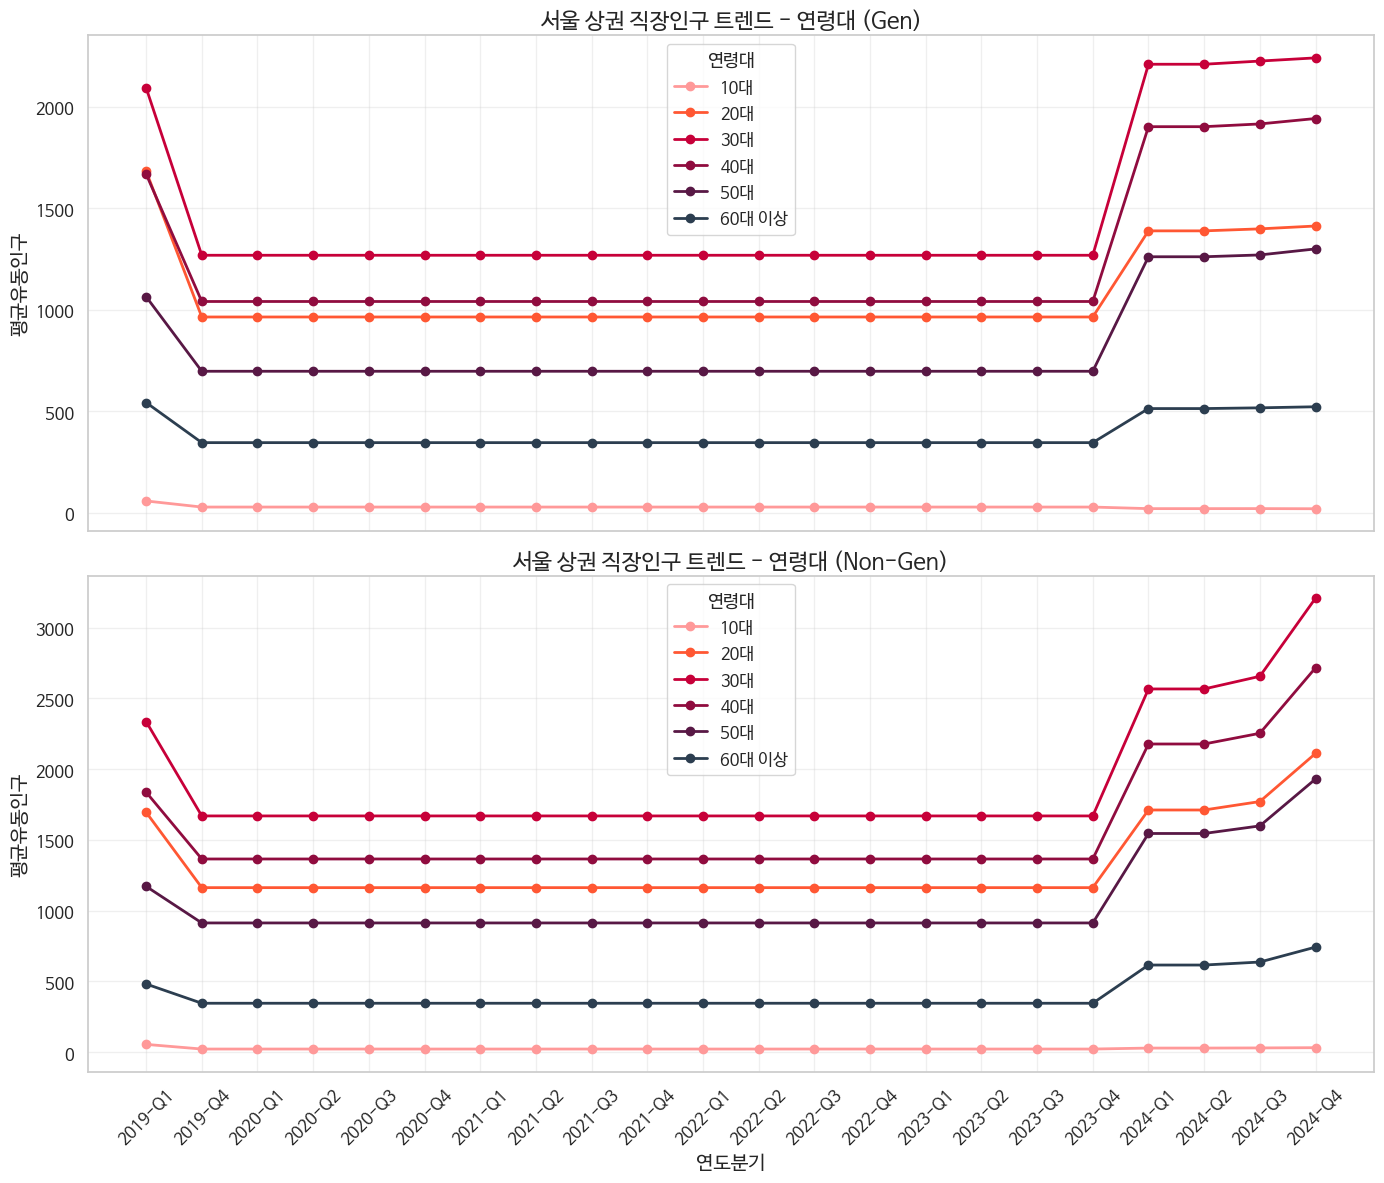

In [37]:
# 연령대 레이블 정의
age_labels = {
  "연령대10직장인구수": "10대",
  "연령대20직장인구수": "20대",
  "연령대30직장인구수": "30대",
  "연령대40직장인구수": "40대",
  "연령대50직장인구수": "50대",
  "연령대60이상직장인구수": "60대 이상"
}

# 데이터 타입 변환
age_columns = [
  "연령대10직장인구수", "연령대20직장인구수", "연령대30직장인구수",
  "연령대40직장인구수", "연령대50직장인구수", "연령대60이상직장인구수"
]

# 연령대별 색상 지정
age_colors = {
  "연령대10직장인구수": "#FF9999",
  "연령대20직장인구수": "#FF5733",
  "연령대30직장인구수": "#C70039",
  "연령대40직장인구수": "#900C3F",
  "연령대50직장인구수": "#581845",
  "연령대60이상직장인구수": "#2C3E50"
}

# 데이터 타입 변환
for col in age_columns:
  df_dong_working_age[col] = pd.to_numeric(df_dong_working_age[col], errors='coerce')

# 연도_분기 컬럼 변환
df_dong_working_age['연도분기라벨'] = df_dong_working_age['연도분기'].astype(str).apply(
  lambda x: f"{x[:4]}-Q{x[4:]}" if len(x) >= 5 else x
)

# 연령대별 시계열 데이터 준비
age_time_series = df_dong_working_age.groupby(['연도분기', '연도분기라벨', '구분']).agg({col: 'mean' for col in age_columns}).reset_index()
age_time_series = age_time_series.sort_values('연도분기')

# 젠트리피케이션, 비젠트리피케이션 데이터 분리
gen_age_data = age_time_series[age_time_series['구분'] == '젠트리피케이션']
non_gen_age_data = age_time_series[age_time_series['구분'] == '비젠트리피케이션']

# 두 개의 서브플롯 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# 젠트리피케이션 지역의 연령대별 직장인구 시계열 그래프
for col in age_columns:
  ax1.plot(gen_age_data['연도분기라벨'], gen_age_data[col], 'o-', color=age_colors[col], linewidth=2, markersize=6, label=age_labels[col])

ax1.set_title('서울 상권 직장인구 트렌드 - 연령대 (Gen)', fontsize=16)
ax1.set_ylabel('평균유동인구', fontsize=14)
ax1.tick_params(axis='y', labelsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(title='연령대', fontsize=12, title_fontsize=13)

# 비젠트리피케이션 지역의 연령대별 직장인구 시계열 그래프
for col in age_columns:
  ax2.plot(non_gen_age_data['연도분기라벨'], non_gen_age_data[col], 'o-', color=age_colors[col], linewidth=2, markersize=6, label=age_labels[col])

ax2.set_title('서울 상권 직장인구 트렌드 - 연령대 (Non-Gen)', fontsize=16)
ax2.set_xlabel('연도분기', fontsize=14)
ax2.set_ylabel('평균유동인구', fontsize=14)
ax2.tick_params(axis='x', rotation=45, labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(title='연령대', fontsize=12, title_fontsize=13)

# 그래프 그리기
plt.tight_layout()
plt.show()

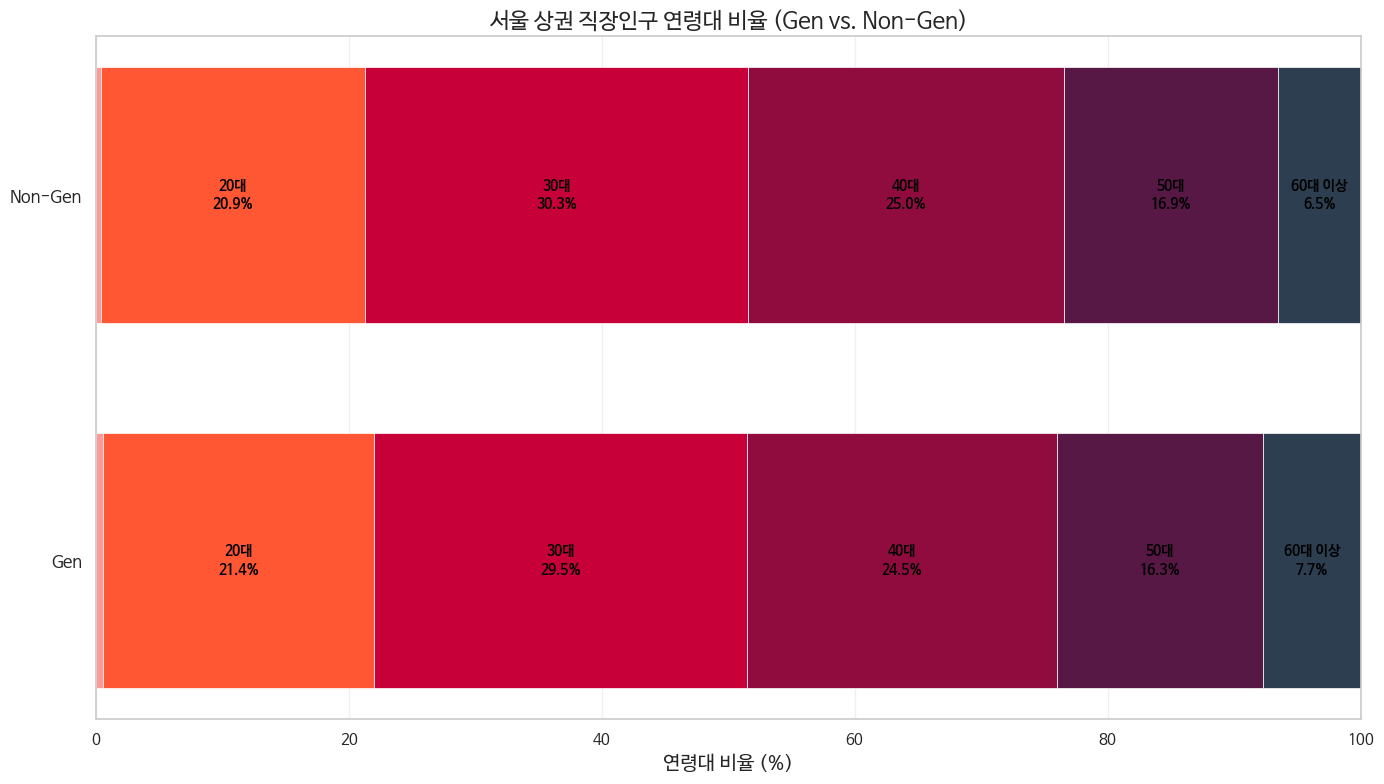

In [38]:
# 각 구분별, 연령대별 평균 직장인구 계산
age_means = df_dong_working_age.groupby('구분')[age_columns].mean().reset_index()

# 각 행(구분)별로 총 합계 계산하여 비율 구하기
for idx, row in age_means.iterrows():
  total = row[age_columns].sum()
  for col in age_columns:
    age_means.loc[idx, f'{col}_비율'] = row[col] / total * 100

# 데이터 재구성 (멜팅)
ratio_columns = [f'{col}_비율' for col in age_columns]
age_ratio_melted = pd.melt(
  age_means,
  id_vars=['구분'],
  value_vars=ratio_columns,
  var_name='연령대_비율',
  value_name='비율'
)

# 연령대 레이블 변환
age_ratio_melted['연령대'] = age_ratio_melted['연령대_비율'].apply(lambda x: age_labels[x.replace('_비율', '')])
age_ratio_melted['구분'] = age_ratio_melted['구분'].map({
  '젠트리피케이션': 'Gen',
  '비젠트리피케이션': 'Non-Gen'
})

# 연령대 순서 정의
age_order = ['10대', '20대', '30대', '40대', '50대', '60대 이상']

# 연령대 순서 컬럼 추가
age_ratio_melted['연령대순서'] = age_ratio_melted['연령대'].map({age: i for i, age in enumerate(age_order)})
age_ratio_melted = age_ratio_melted.sort_values(['구분', '연령대순서'])

# 색상 팔레트 정의 (연령대별)
colors = ['#FF9999', '#FF5733', '#C70039', '#900C3F', '#581845', '#2C3E50']
palette = {age: color for age, color in zip(age_order, colors)}

# 그래프 크기 설정
plt.figure(figsize=(14, 8))

# 젠트리피케이션과 비젠트리피케이션을 구분하여 그래프 생성
for i, category in enumerate(['Gen', 'Non-Gen']):
  # 해당 카테고리 데이터만 필터링
  category_data = age_ratio_melted[age_ratio_melted['구분'] == category]

  # 위치 설정 (젠트리피케이션: 0, 비젠트리피케이션: 1)
  y_pos = i

  # 누적 시작 위치
  left = 0

  # 각 연령대별로 막대 그리기
  for age in age_order:
    # 해당 연령대 데이터 찾기
    age_data = category_data[category_data['연령대'] == age]

    if not age_data.empty:
      width = age_data['비율'].values[0]
      plt.barh(y_pos, width, left=left, height=0.7, color=palette[age], edgecolor='white', linewidth=0.5)

      # 비율이 5% 이상인 경우에만 레이블 표시
      if width >= 5:
        # 텍스트 위치 계산 (막대 중앙)
        text_x = left + width / 2
        plt.text(text_x, y_pos, f"{age}\n{width:.1f}%", ha='center', va='center', color='black', fontsize=10, fontweight='bold')

      # 다음 막대의 시작 위치 업데이트
      left += width

# 그래프 그리기
plt.yticks([0, 1], ['Gen', 'Non-Gen'], fontsize=12)
plt.xlabel('연령대 비율 (%)', fontsize=14)
plt.xlim(0, 100)
plt.title('서울 상권 직장인구 연령대 비율 (Gen vs. Non-Gen)', fontsize=16)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()